In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import keras
from keras.utils  import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Conv3D, ConvLSTM2D, BatchNormalization
from keras.models import Sequential
# from keras.layers.convolutional import Conv3D
# from keras.layers.convolutional_recurrent import ConvLSTM2D
# from keras.layers.normalization import BatchNormalization

import matplotlib.pyplot as plt
import os
import time

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile
import os

zip_train = zipfile.ZipFile('/content/drive/MyDrive/Colab_Notebooks/single_pendulum.zip','r')
zip_train.extractall('/tmp')
zip_train.close()


In [10]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

In [11]:
encoder = keras.Model(input_img, encoded)

In [12]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [13]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [14]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [15]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [16]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 8s 11ms/step - loss: 0.2760 - val_loss: 0.1895
Epoch 2/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1709 - val_loss: 0.1528
Epoch 3/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1436 - val_loss: 0.1333
Epoch 4/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1282 - val_loss: 0.1208
Epoch 5/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1180 - val_loss: 0.1126
Epoch 6/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1112 - val_loss: 0.1072
Epoch 7/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1065 - val_loss: 0.1032
Epoch 8/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1029 - val_loss: 0.1000
Epoch 9/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1000 - val_loss: 0.0976
Epoch 10/50
235/235 [==============================] - 3s 12ms/step - loss: 0.0979 - val_loss: 0.09

In [17]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 1s 1ms/step


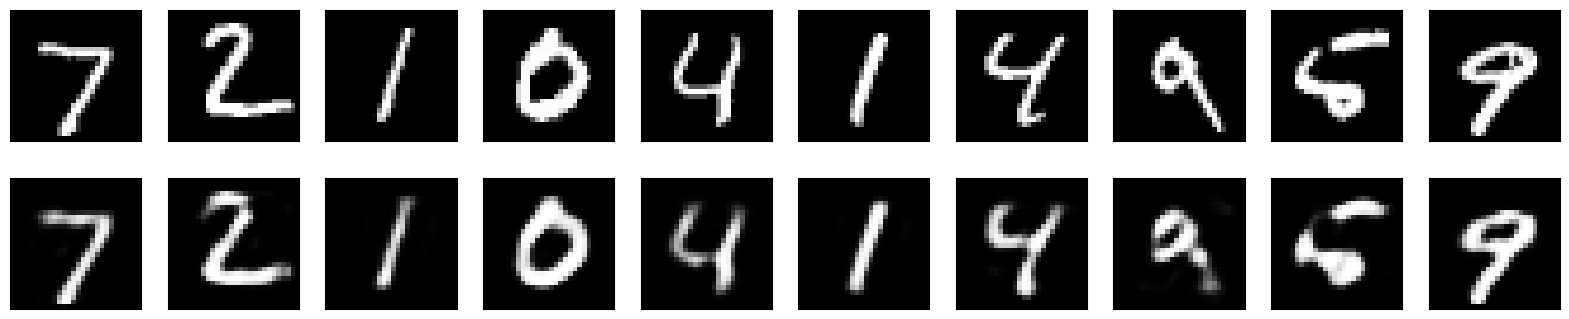

In [18]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [12]:
y = [f'{x}' for x in range(0,26)]
print(y)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25']


In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = "/tmp/single_pendulum"

# Get a list of all folder names in the data directory
class_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]

# Split into training and validation sets
train_folders, temp_folders = train_test_split(class_folders, test_size=0.2, random_state=42)
# Split the remaining into validation and test sets
validation_folders, test_folders = train_test_split(temp_folders, test_size=0.5, random_state=42)

# Create an ImageDataGenerator for data loading and augmentation
datagen = ImageDataGenerator(rescale=1./255)


# datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
img_height, img_width = 128, 128

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=60,
    classes=train_folders,
    class_mode='input',
    shuffle=False,
    seed=42  # Use the same seed for reproducibility
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=60,
    classes=validation_folders,
    class_mode='input',
    shuffle=False,
    seed=42  # Use the same seed for reproducibility
)

test_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=60,
    classes=test_folders,
    class_mode='input',
    shuffle=False  # Set shuffle to False for testing
)


Found 57600 images belonging to 960 classes.
Found 7200 images belonging to 120 classes.
Found 7200 images belonging to 120 classes.


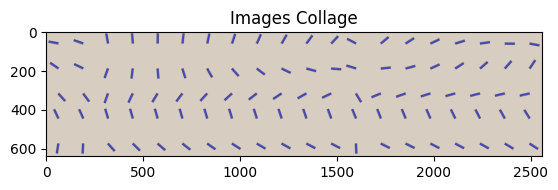

In [31]:
# make tensorflow datasets from the generators
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),
    )
)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: validation_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),
    )
)

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),
    )
)

# plot images per class
def plot_images_collage(dataset, num_classes=5, num_images_per_class=5):
    images_per_class = []

    # Extract images from the dataset
    for images, _ in dataset.take(num_classes):
        images_per_class.append(images[:num_images_per_class])

    # Reshape and concatenate images for each class
    images_collage = []
    for i in range(num_images_per_class):
        images_collage.append(tf.concat([img[i] for img in images_per_class], axis=0))

    # Concatenate images horizontally to create a collage
    collage = tf.concat(images_collage, axis=1)

    # Display the collage
    plt.imshow(collage.numpy())
    plt.title("Images Collage")
    plt.show()

# Example usage with the training dataset
plot_images_collage(train_dataset, num_classes=5, num_images_per_class=20)



In [ ]:
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

data_dir = "/tmp/single_pendulum/"

def make_dataset(folder_list):
  img_array = []
  for folder_num in range(len(folder_list)):
    folder = data_dir + f'{folder_num}'
    if os.path.isdir(folder):
      for img_num in range(60):
        img_path = folder + f'/{img_num}.png'
        if os.path.isfile(img_path):
          img = cv2.imread(img_path)
          img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          img_array.append(img_rgb)
  return np.array(img_array) / 255.0


# Get a list of all folder names in the data directory
class_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]

# Split into training and validation sets
train_folders, temp_folders = train_test_split(class_folders, test_size=0.2, random_state=42)
# Split the remaining into validation and test sets
validation_folders, test_folders = train_test_split(temp_folders, test_size=0.5, random_state=42)

train_dataset = make_dataset(train_folders)
valid_dataset = make_dataset(validation_folders)
test_dataset = make_dataset(test_folders)

print(train_dataset.shape)
#dim of (num folders * num images per seq, img height, img width, rgb)



In [28]:
seq = Sequential()

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   input_shape=(None, 128, 128, 1),
                   padding='same', return_sequences=False))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=False))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=False))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=False))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adadelta')

In [4]:
import keras
from keras import layers
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(),
)

NameError: ignored

WORKING TO AUTOENCODE, REALLY REALLY BAD LOSS THOUGH

In [20]:
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

data_dir = "/tmp/single_pendulum/"

num_train_folders = 400
num_val_folders = 200
num_test_folders = 200
img_size = 64
num_imgs = 30

def make_dataset(folder_list):
    img_array = []
    for folder_num in folder_list:
        folder = os.path.join(data_dir, str(folder_num))
        if os.path.isdir(folder):
            for img_num in range(num_imgs):  # change to 60 if can handle it
                img_path = os.path.join(folder, f'{img_num}.png')
                if os.path.isfile(img_path):
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, (img_size, img_size))
                    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    # img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img_array.append(img_gray)
    img_array = np.array(img_array)
    img_array = img_array.reshape(len(folder_list), num_imgs, img_size, img_size, 1)
    return np.array(img_array) / 255.0

# Get a list of all folder names in the data directory
class_folders = [int(f) for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]

# Limit the number of folders for training, validation, and testing
train_folders, remaining_folders = train_test_split(class_folders, test_size=num_train_folders / len(class_folders), random_state=42)
val_test_folders, test_folders = train_test_split(remaining_folders, test_size=num_test_folders / len(remaining_folders), random_state=42)
val_folders, test_folders = train_test_split(val_test_folders, test_size=0.5, random_state=42)

train_dataset = make_dataset(train_folders[:num_train_folders])
valid_dataset = make_dataset(val_folders[:num_val_folders])
test_dataset = make_dataset(test_folders[:num_test_folders])



In [21]:
def create_shifted_frames(dataset):
    x = dataset[:, 0 : dataset.shape[1] - 1, :, :] #excludes last frame
    y = dataset[:, 1 : dataset.shape[1], :, :] #excludes first frame (shifted over)
    return x, y

x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(valid_dataset)
x_test, y_test = create_shifted_frames(test_dataset)

print(x_train.shape)
print(y_train.shape)

(400, 29, 64, 64, 1)
(400, 29, 64, 64, 1)


Displaying frames for example 219.


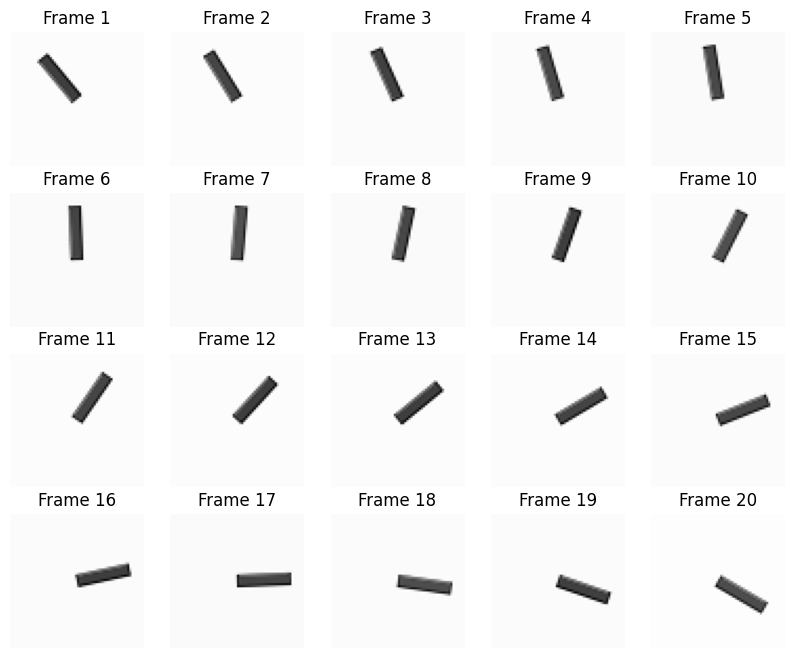

In [22]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [23]:
import keras.layers as layers
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(),
)

In [24]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 10
batch_size = 1

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)


Epoch 1/10
400/400 [==============================] - 76s 177ms/step - loss: 0.5146 - val_loss: 0.5321 - lr: 0.0010
Epoch 2/10
400/400 [==============================] - 70s 175ms/step - loss: 0.5081 - val_loss: 0.5431 - lr: 0.0010
Epoch 3/10
400/400 [==============================] - 70s 174ms/step - loss: 0.5076 - val_loss: 0.5473 - lr: 0.0010
Epoch 4/10
400/400 [==============================] - 70s 174ms/step - loss: 0.5073 - val_loss: 0.5377 - lr: 0.0010
Epoch 5/10
400/400 [==============================] - 70s 174ms/step - loss: 0.5087 - val_loss: 0.5523 - lr: 0.0010
Epoch 6/10
400/400 [==============================] - 70s 174ms/step - loss: 0.5077 - val_loss: 0.5280 - lr: 0.0010
Epoch 7/10
400/400 [==============================] - 70s 174ms/step - loss: 0.5071 - val_loss: 0.5271 - lr: 0.0010
Epoch 8/10
400/400 [==============================] - 70s 174ms/step - loss: 0.5068 - val_loss: 0.5227 - lr: 0.0010
Epoch 9/10
400/400 [==============================] - 69s 174ms/step - l

In [28]:
import random
from matplotlib.backends.backend_pdf import PdfPages

pdf_filename = "/output_frames_v6.pdf"
pdf_pages = PdfPages(pdf_filename)

index = 0

for i in range(30):
    # Select a random example from the validation dataset.
    example = test_dataset[random.randrange(0,49)]

    # Pick the first/last ten frames from the example.
    frames = example[:5, ...]
    original_frames = example[5:, ...]

    # Predict a new set of 10 frames.
    for _ in range(5):
        # Extract the model's prediction and post-process it.
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        frames = np.concatenate((frames, predicted_frame), axis=0)

    # Construct a figure for the original and new frames.
    fig, axes = plt.subplots(2, 5, figsize=(20, 4))

    # Plot the original frames.
    for idx, ax in enumerate(axes[0]):
        ax.imshow(original_frames[idx], cmap='gray')
        ax.set_title(f"Frame {idx + 11}")
        ax.axis("off")

    # Plot the new frames.
    new_frames = frames[5:, ...]
    for idx, ax in enumerate(axes[1]):
        ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
        ax.set_title(f"Frame {idx + 11}")
        ax.axis("off")

    # Display the figure.
    # Save the current figure to the PDF.
    pdf_pages.savefig(fig, bbox_inches="tight")
    plt.close(fig)
    # index=0
    # plt.savefig("./r" + str(index) + ".png", bbox_inches="tight")
    # index += 1
    # plt.show()
pdf_pages.close()

1/1 [==============================] - 0s 28ms/step


In [27]:
model.save('/model_v6.keras')

1/1 [==============================] - 0s 29ms/step


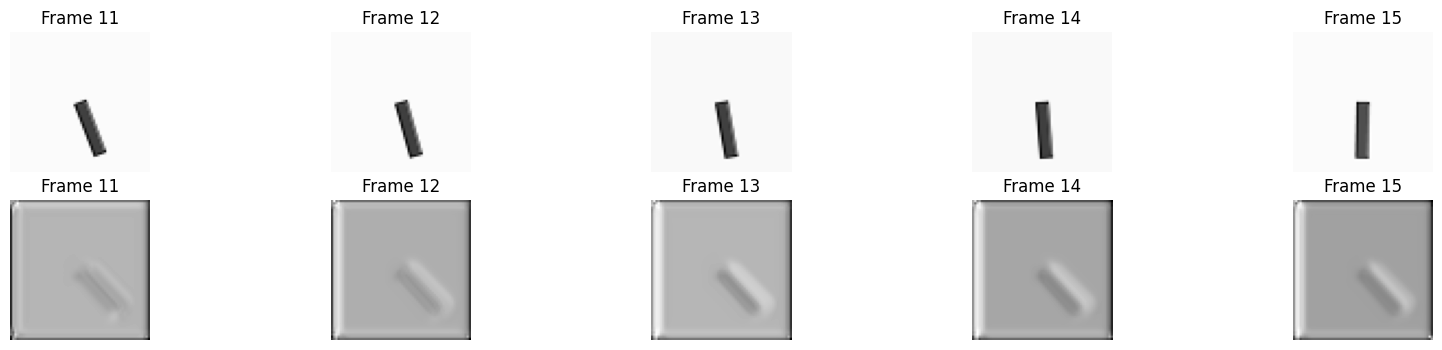

1/1 [==============================] - 0s 30ms/step


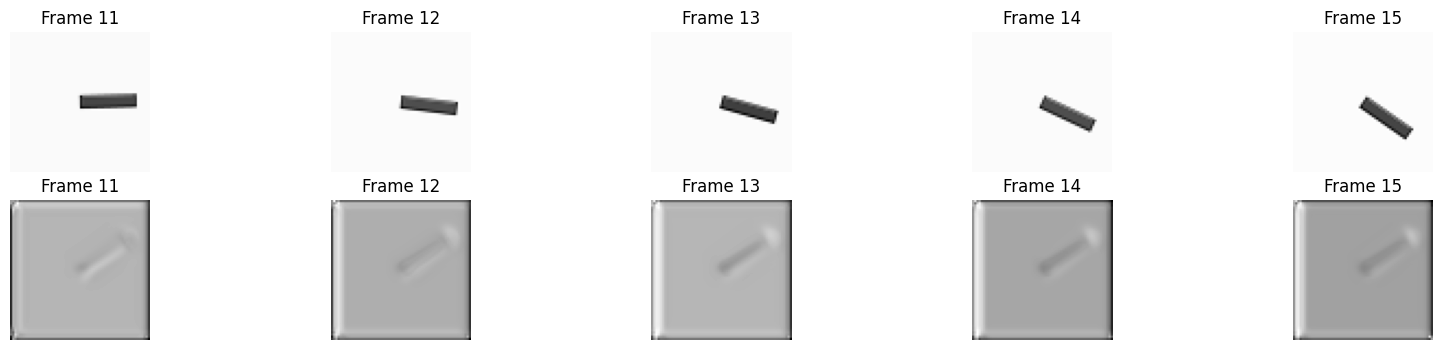

1/1 [==============================] - 0s 28ms/step


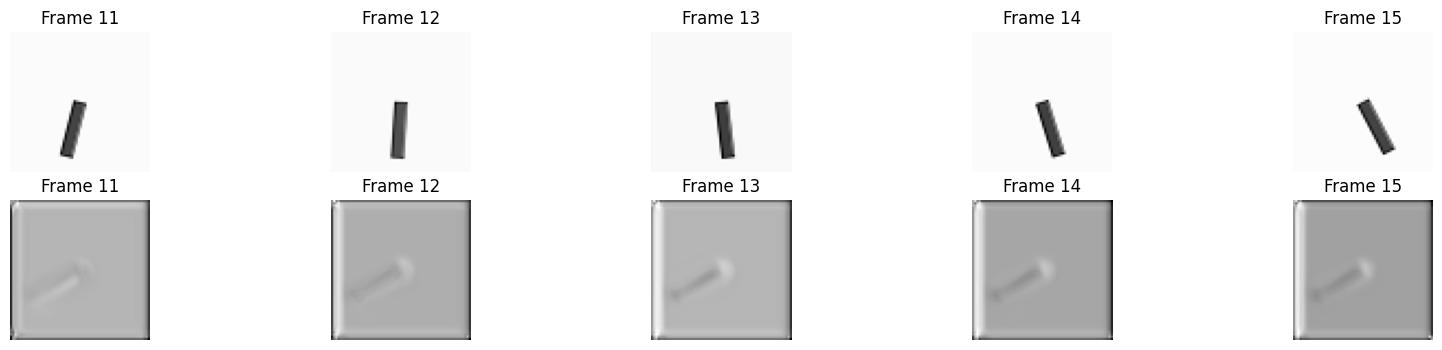

1/1 [==============================] - 0s 29ms/step


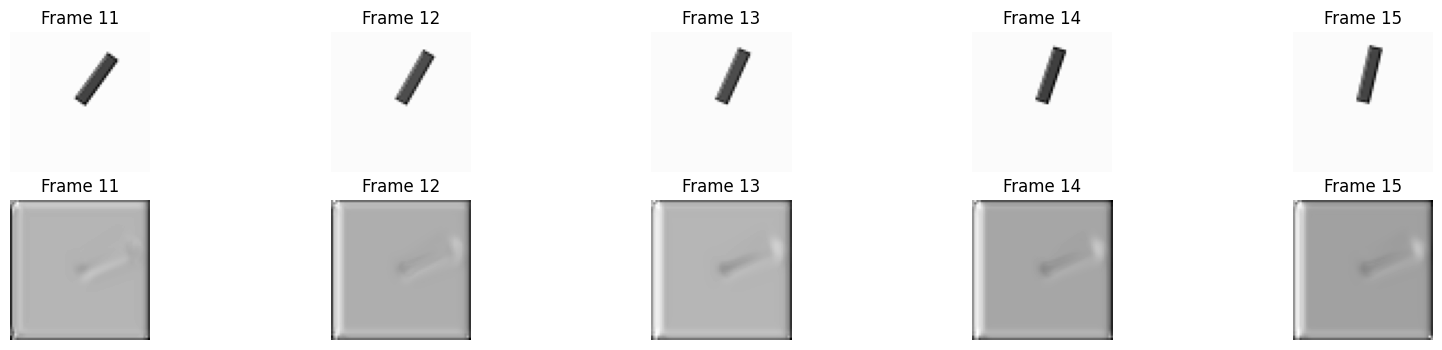

1/1 [==============================] - 0s 30ms/step


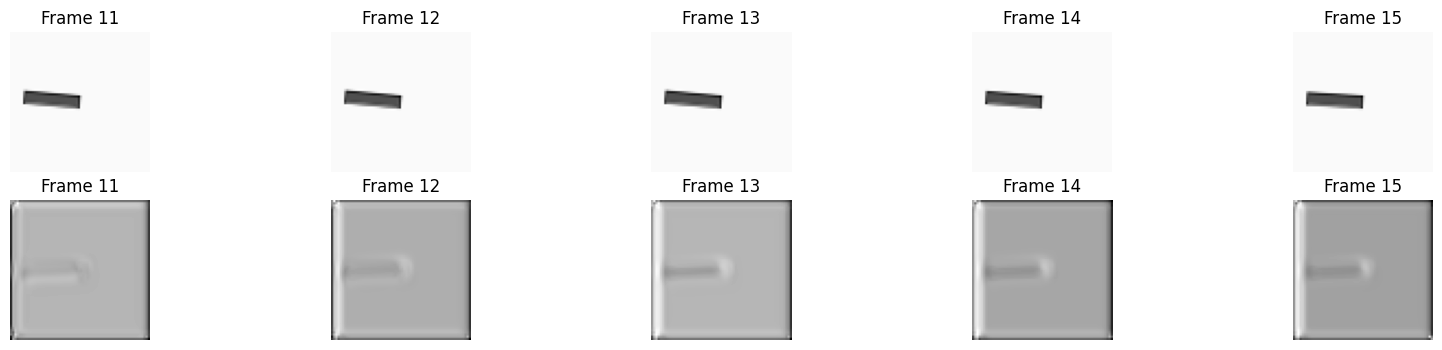

In [29]:

import random
for i in range(5):
    # Select a random example from the validation dataset.
    example = train_dataset[random.randrange(0,199)]

    # Pick the first/last ten frames from the example.
    frames = example[:5, ...]
    original_frames = example[5:, ...]

    # Predict a new set of 10 frames.
    for _ in range(5):
        # Extract the model's prediction and post-process it.
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        frames = np.concatenate((frames, predicted_frame), axis=0)

    # Construct a figure for the original and new frames.
    fig, axes = plt.subplots(2, 5, figsize=(20, 4))

    # Plot the original frames.
    for idx, ax in enumerate(axes[0]):
        ax.imshow(original_frames[idx], cmap='gray')
        ax.set_title(f"Frame {idx + 11}")
        ax.axis("off")

    # Plot the new frames.
    new_frames = frames[5:, ...]
    for idx, ax in enumerate(axes[1]):
        ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
        ax.set_title(f"Frame {idx + 11}")
        ax.axis("off")

    # Display the figure.
    index=0
    # plt.savefig("./r" + str(index) + ".png", bbox_inches="tight")
    index += 1
    plt.show()

1/1 [==============================] - 0s 30ms/step


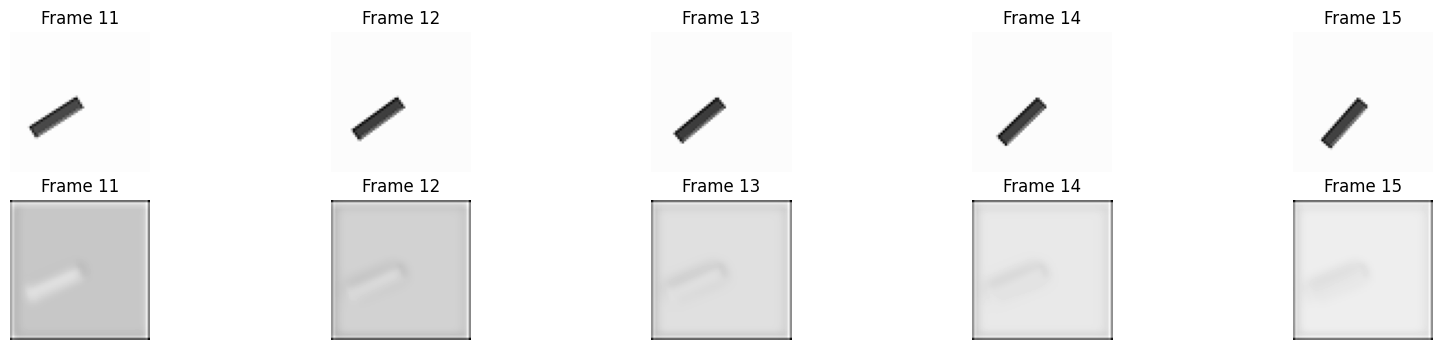

1/1 [==============================] - 0s 31ms/step


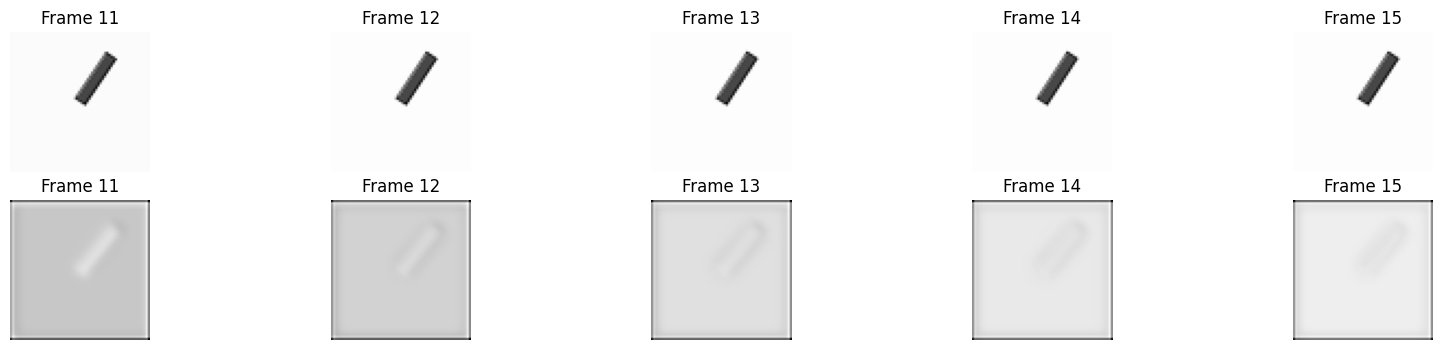

1/1 [==============================] - 0s 32ms/step


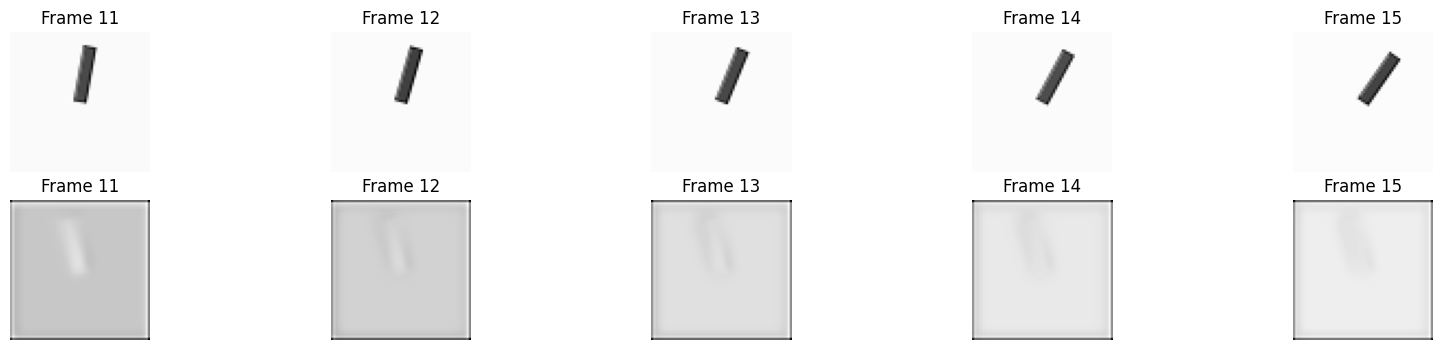

1/1 [==============================] - 0s 30ms/step


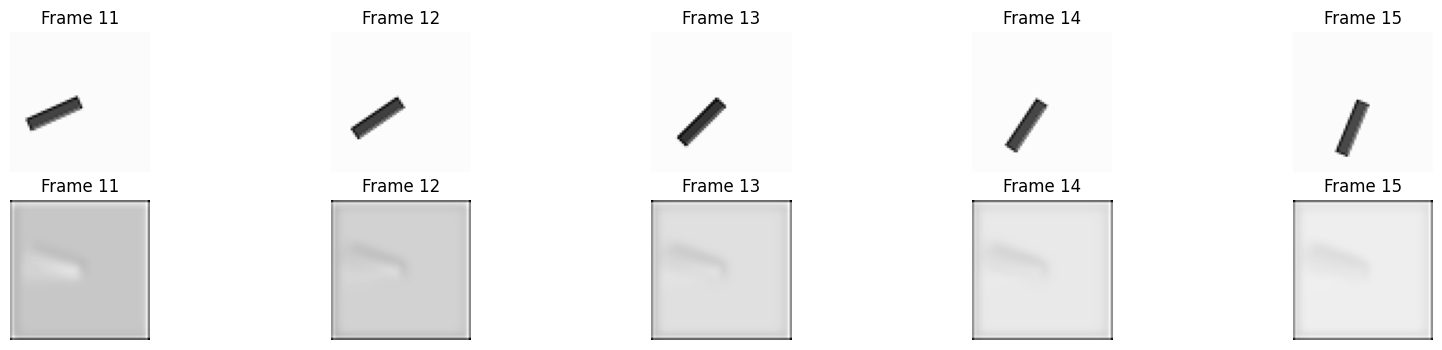

1/1 [==============================] - 0s 30ms/step


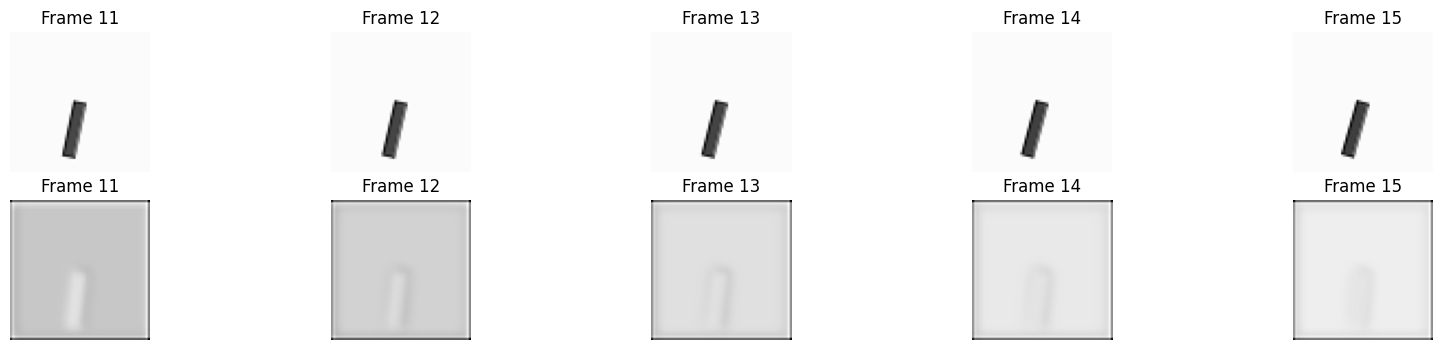

In [10]:
#V2 Redo Code images (before V5)

import random
for i in range(5):
    # Select a random example from the validation dataset.
    example = train_dataset[random.randrange(0,199)]

    # Pick the first/last ten frames from the example.
    frames = example[:5, ...]
    original_frames = example[5:, ...]

    # Predict a new set of 10 frames.
    for _ in range(5):
        # Extract the model's prediction and post-process it.
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        frames = np.concatenate((frames, predicted_frame), axis=0)

    # Construct a figure for the original and new frames.
    fig, axes = plt.subplots(2, 5, figsize=(20, 4))

    # Plot the original frames.
    for idx, ax in enumerate(axes[0]):
        ax.imshow(original_frames[idx], cmap='gray')
        ax.set_title(f"Frame {idx + 11}")
        ax.axis("off")

    # Plot the new frames.
    new_frames = frames[5:, ...]
    for idx, ax in enumerate(axes[1]):
        ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
        ax.set_title(f"Frame {idx + 11}")
        ax.axis("off")

    # Display the figure.
    index=0
    # plt.savefig("./r" + str(index) + ".png", bbox_inches="tight")
    index += 1
    plt.show()

1/1 [==============================] - 0s 52ms/step


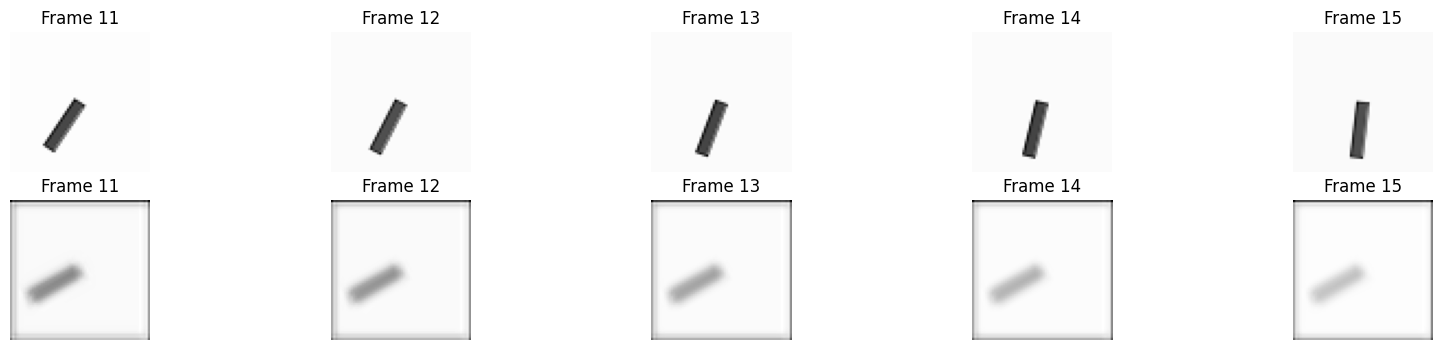

1/1 [==============================] - 0s 33ms/step


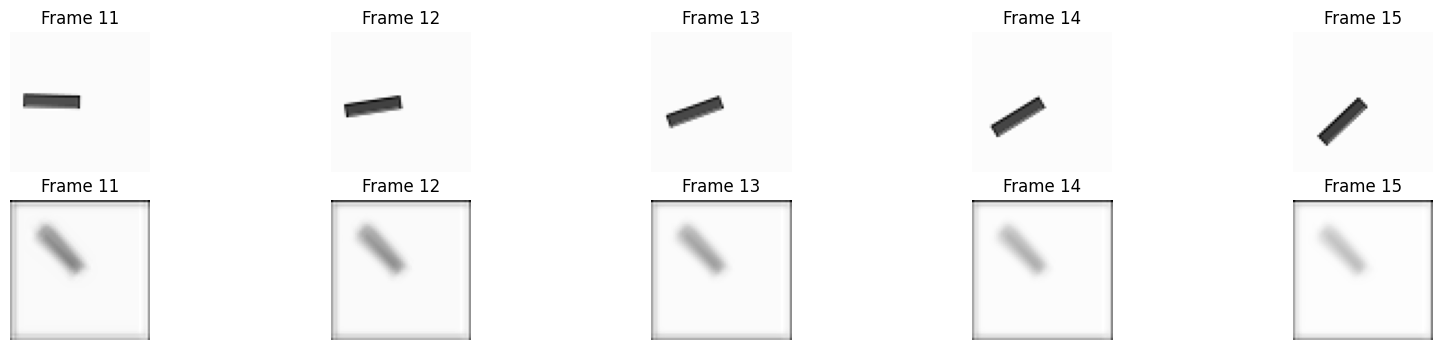

1/1 [==============================] - 0s 31ms/step


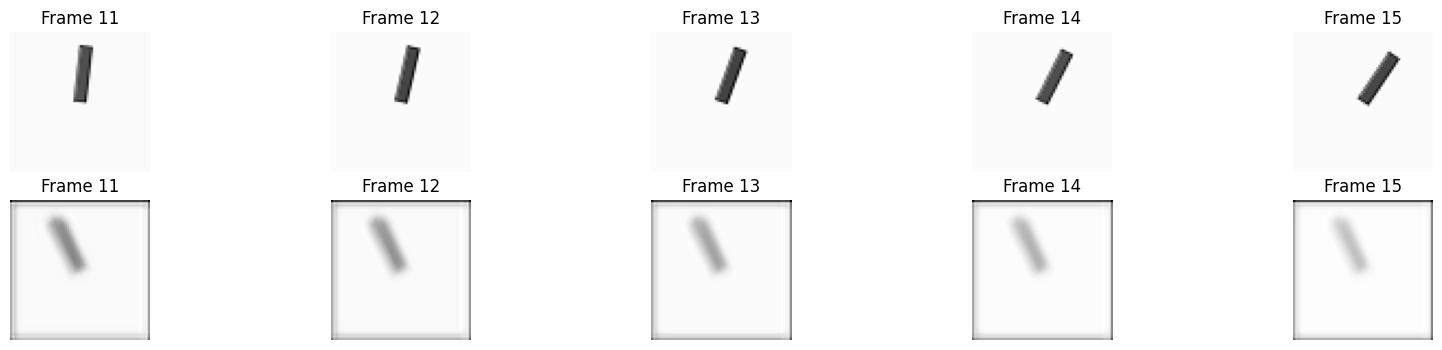

1/1 [==============================] - 0s 34ms/step


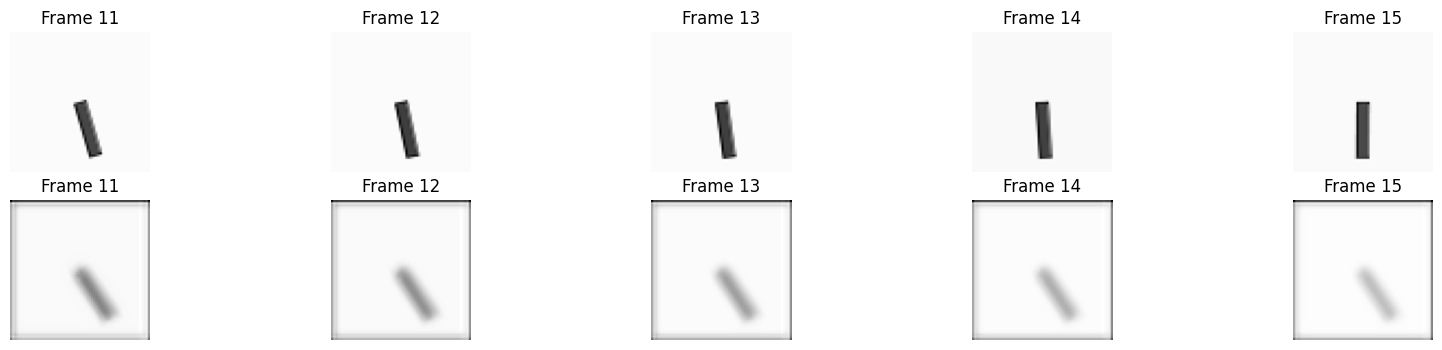

1/1 [==============================] - 0s 33ms/step


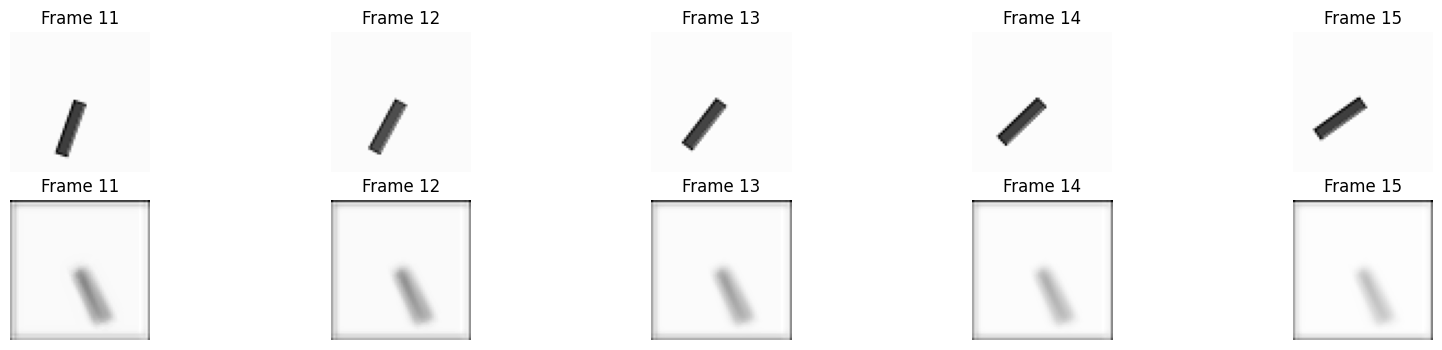

1/1 [==============================] - 0s 30ms/step


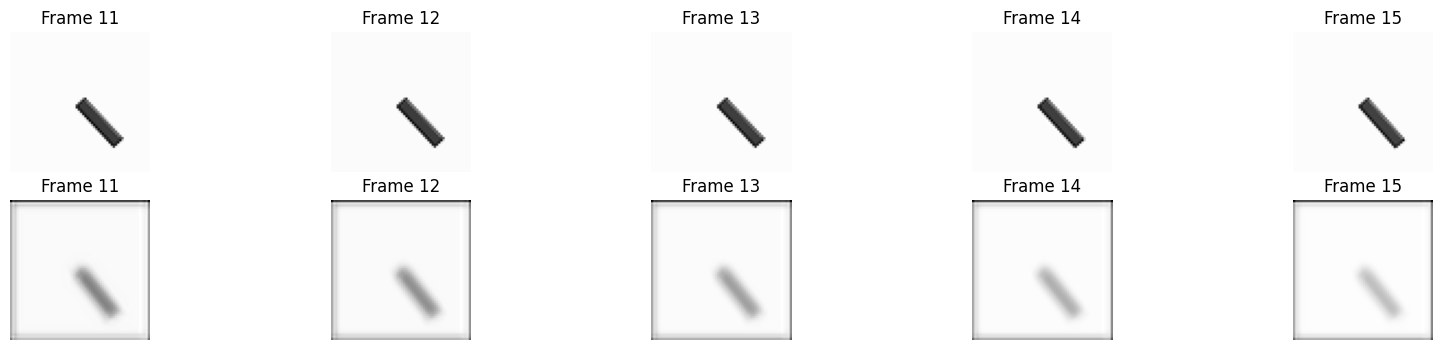

1/1 [==============================] - 0s 32ms/step


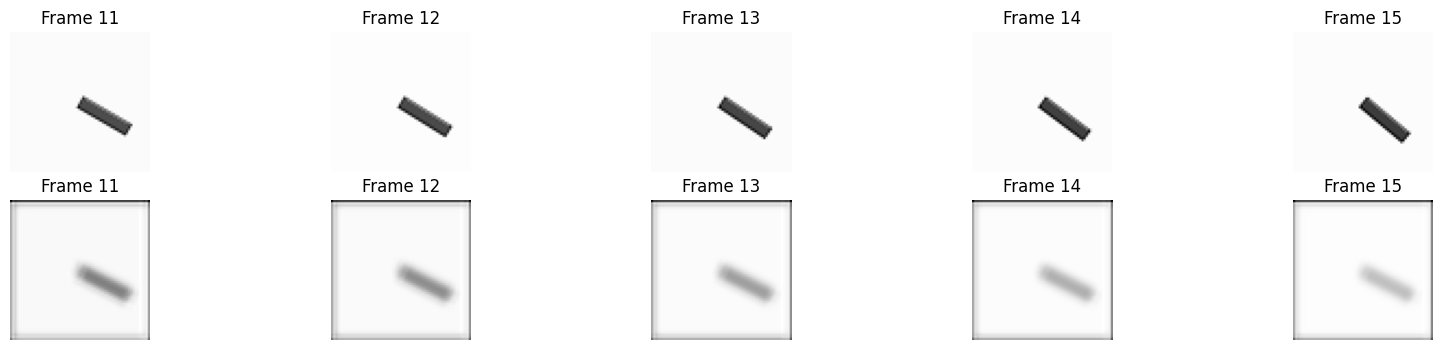

1/1 [==============================] - 0s 32ms/step


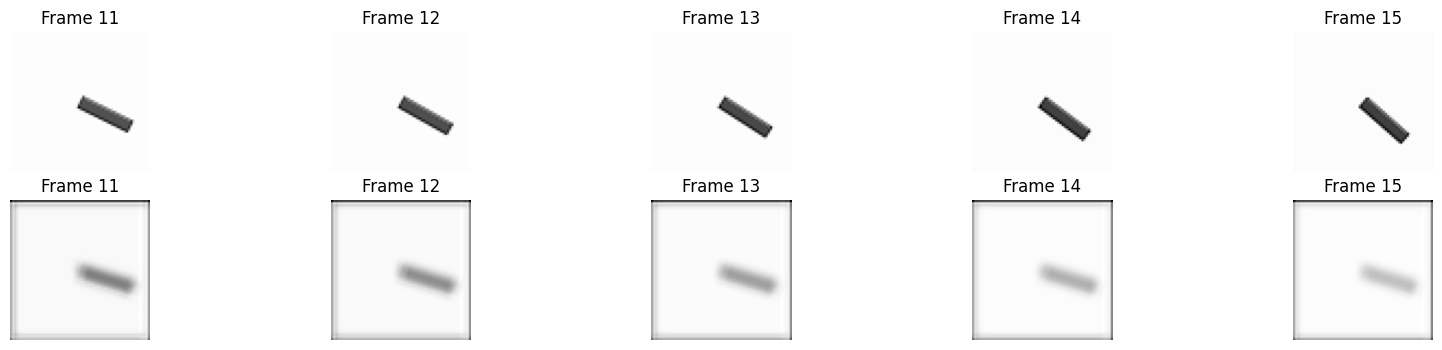

1/1 [==============================] - 0s 34ms/step


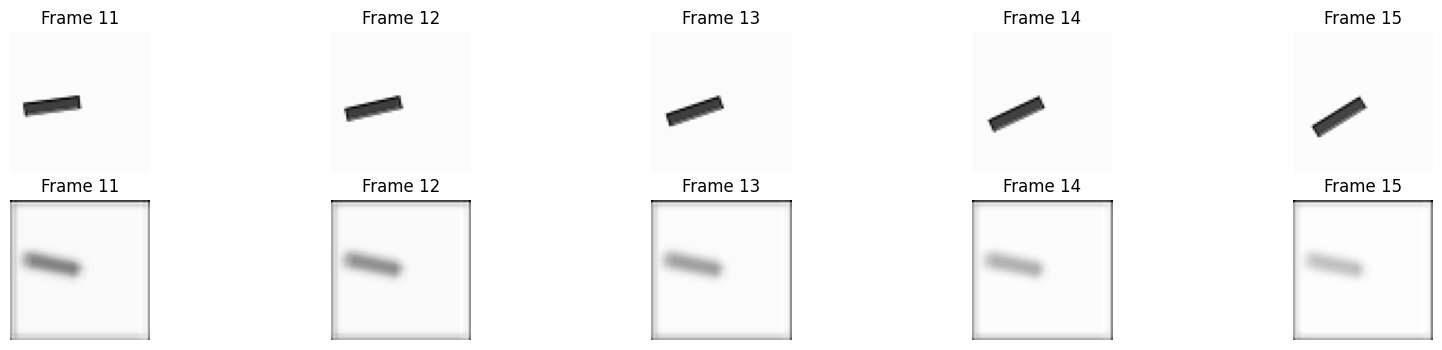

1/1 [==============================] - 0s 32ms/step


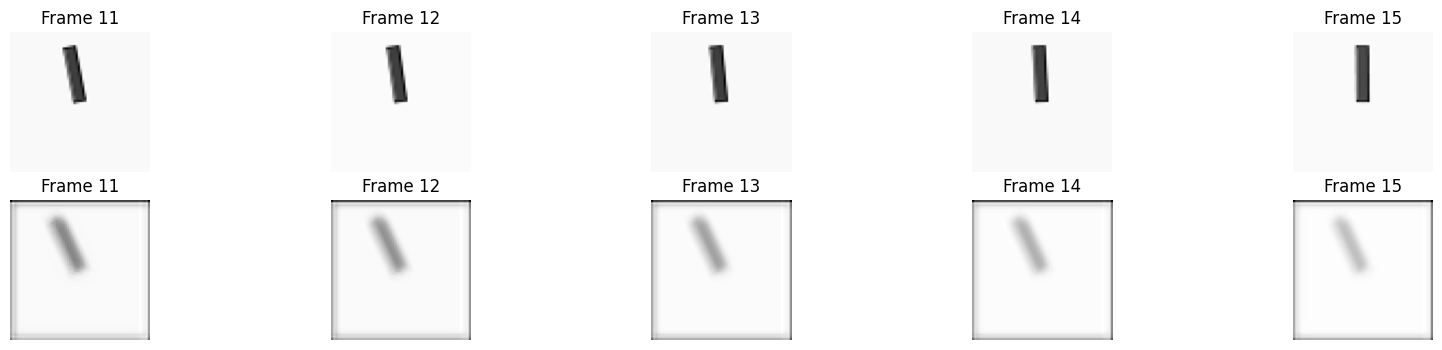

1/1 [==============================] - 0s 31ms/step


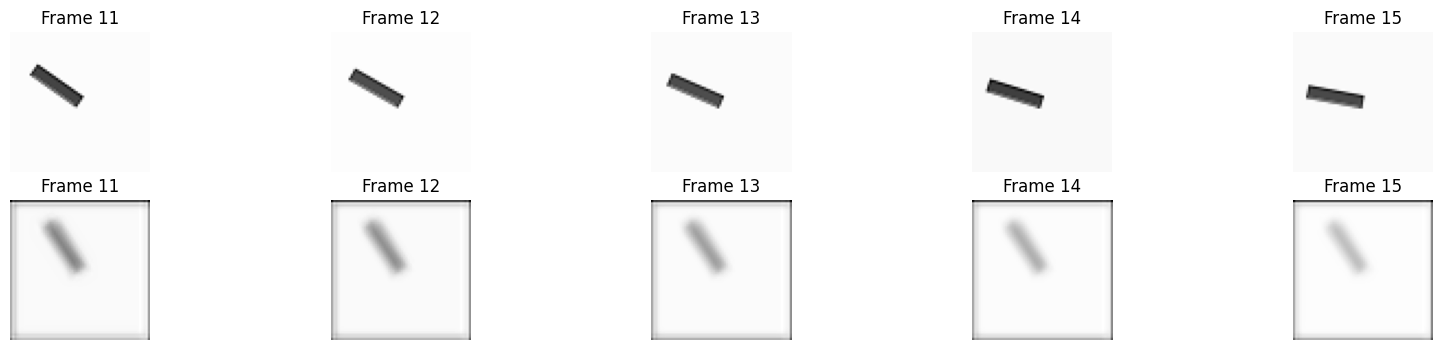

1/1 [==============================] - 0s 31ms/step


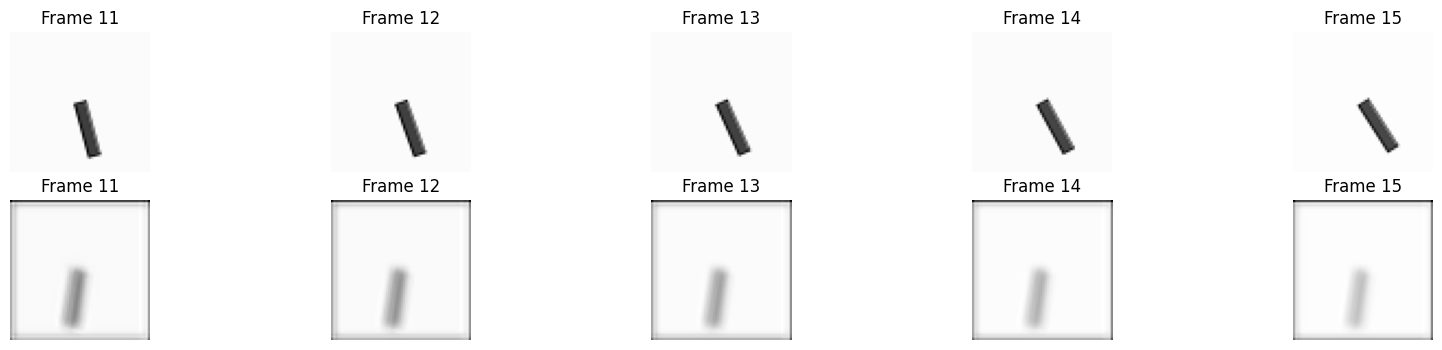

1/1 [==============================] - 0s 31ms/step


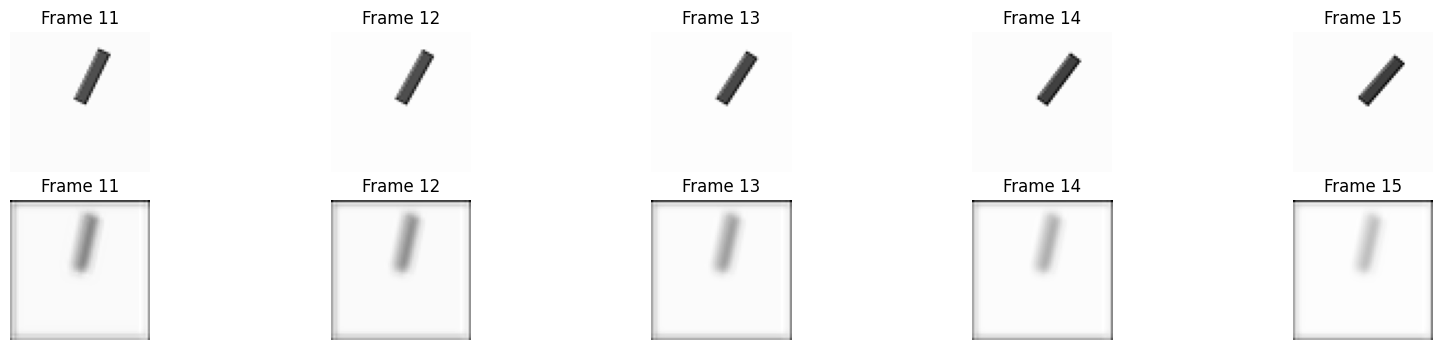

1/1 [==============================] - 0s 34ms/step


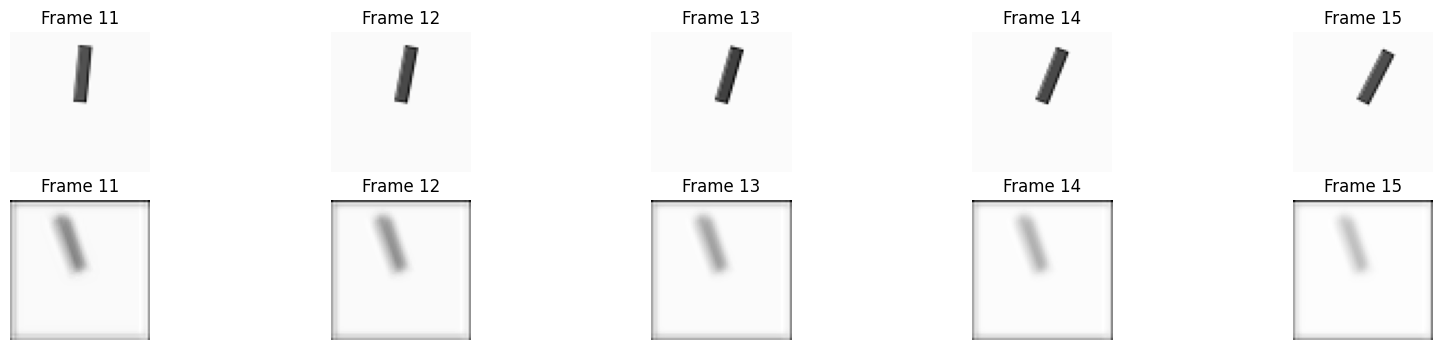

1/1 [==============================] - 0s 30ms/step


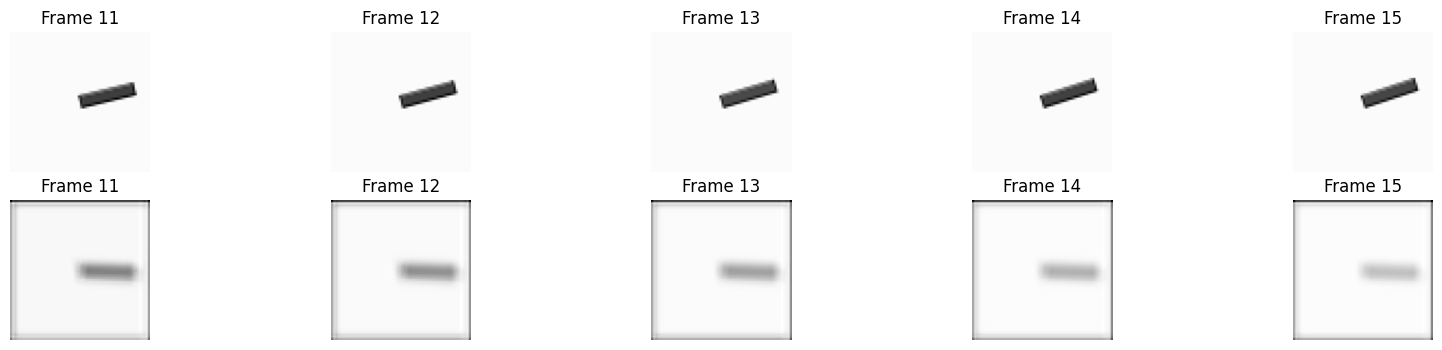

1/1 [==============================] - 0s 32ms/step


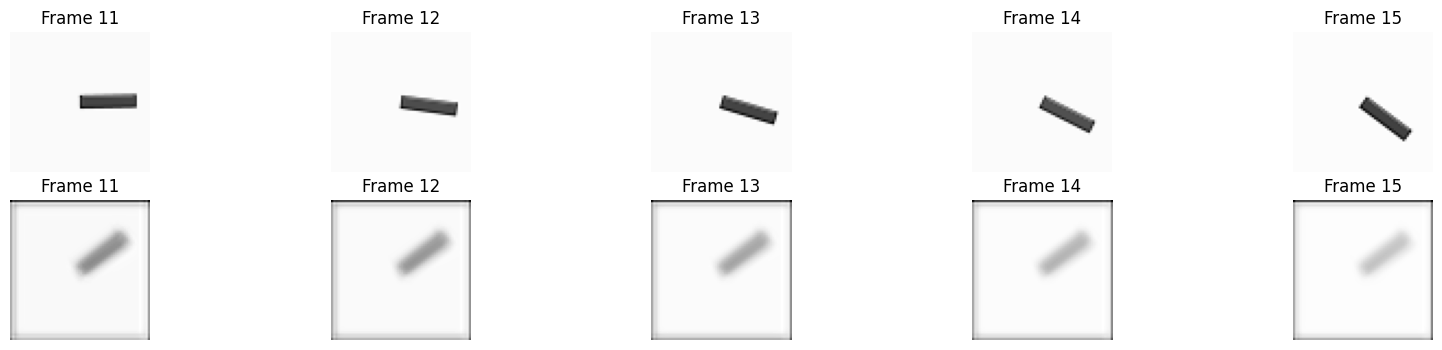

1/1 [==============================] - 0s 31ms/step


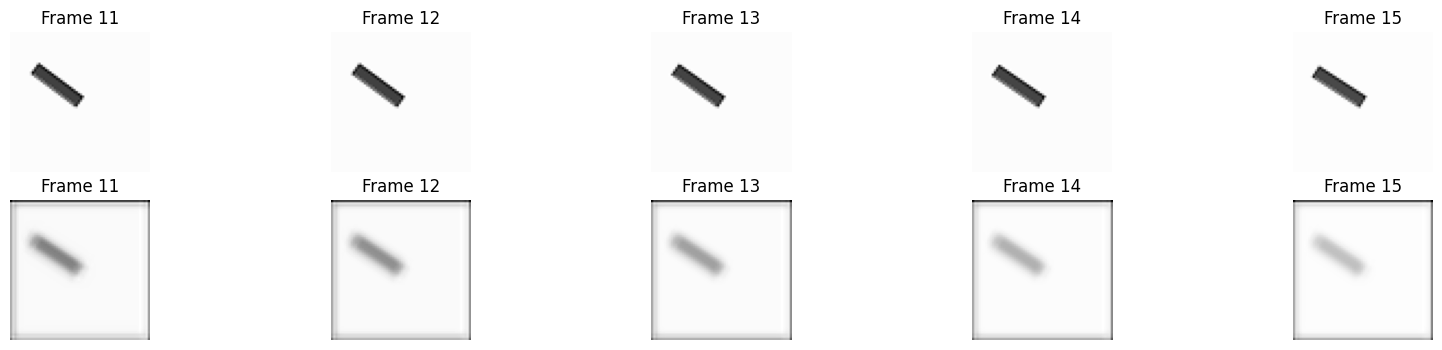

1/1 [==============================] - 0s 32ms/step


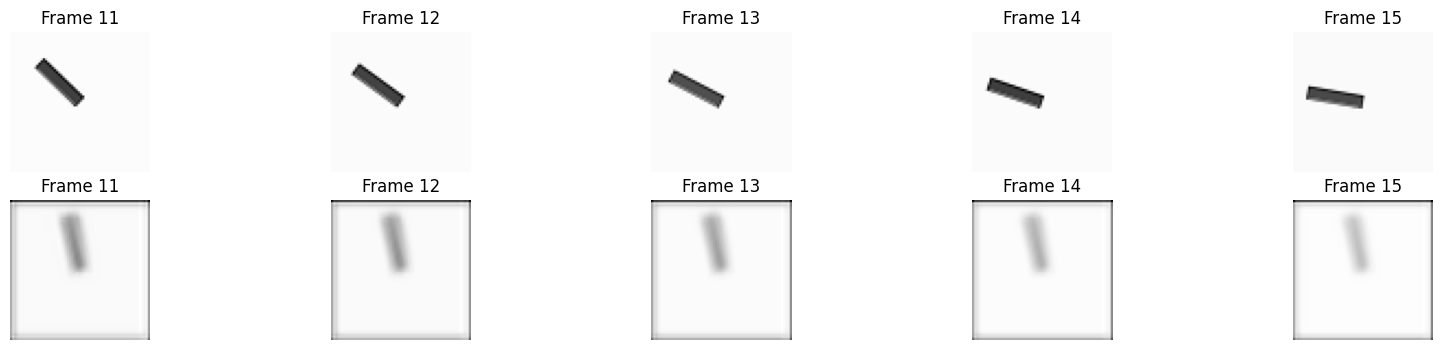

1/1 [==============================] - 0s 31ms/step


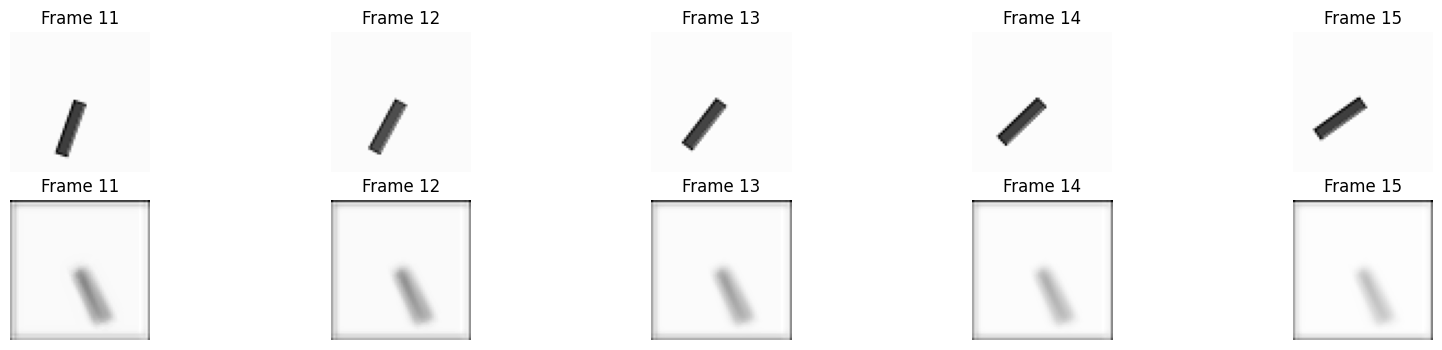

1/1 [==============================] - 0s 32ms/step


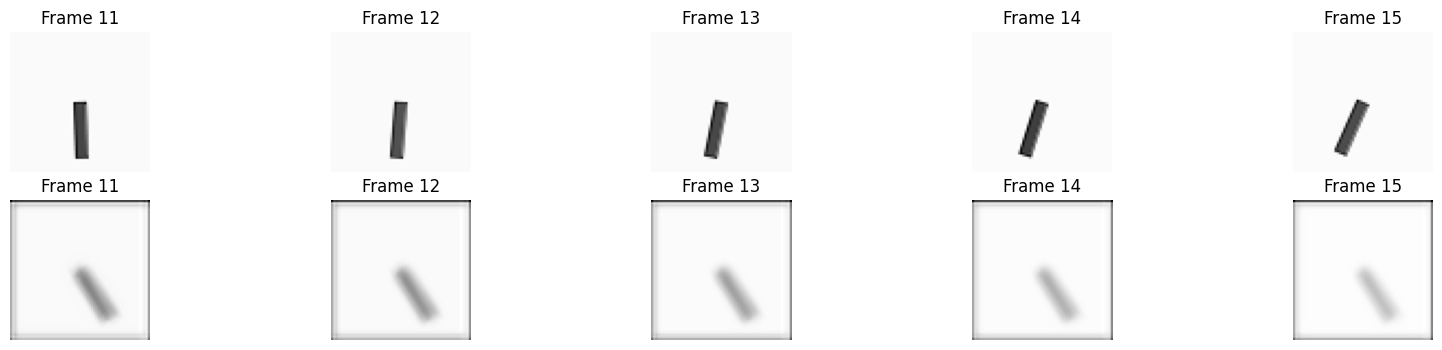

1/1 [==============================] - 0s 37ms/step


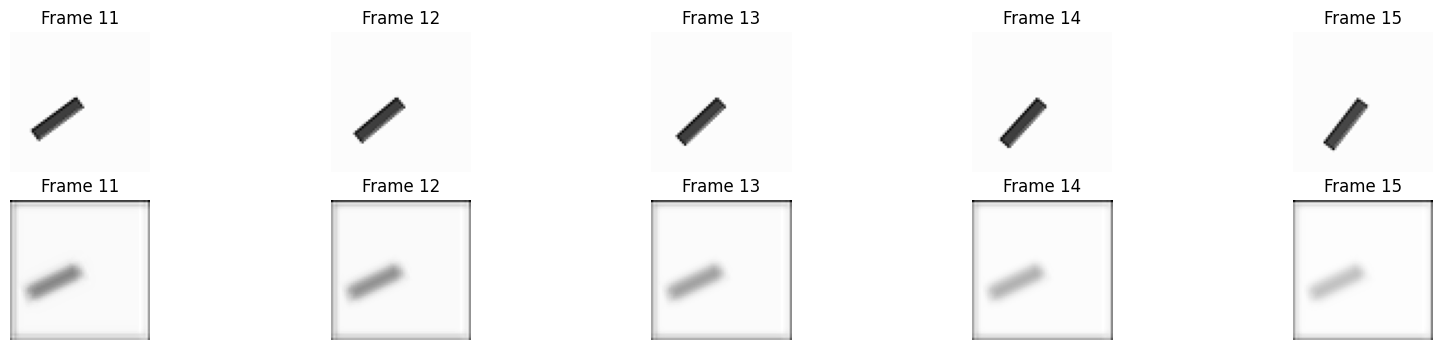

1/1 [==============================] - 0s 32ms/step


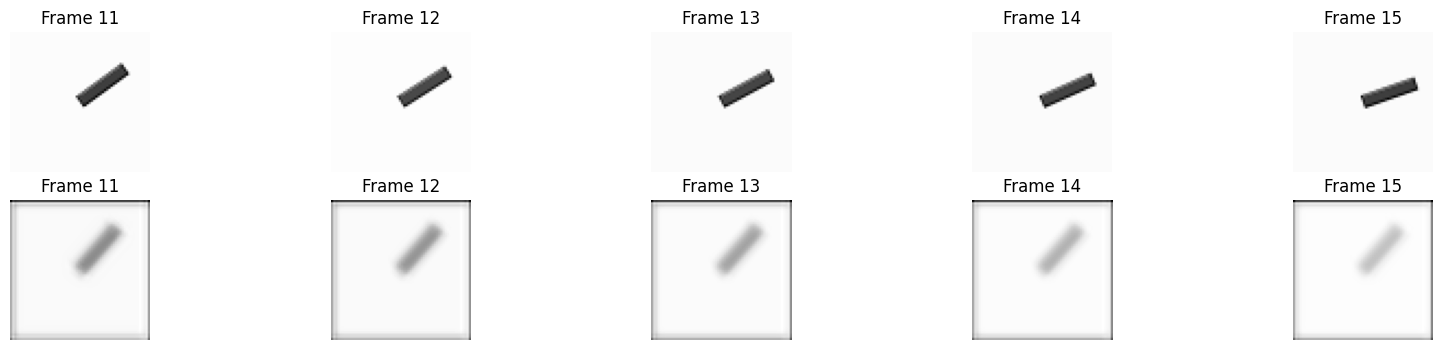

1/1 [==============================] - 0s 35ms/step


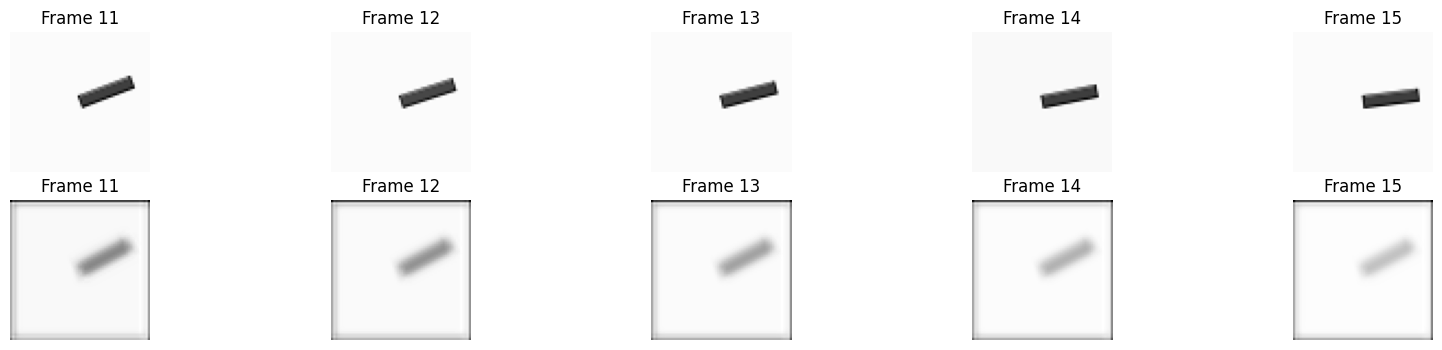

1/1 [==============================] - 0s 44ms/step


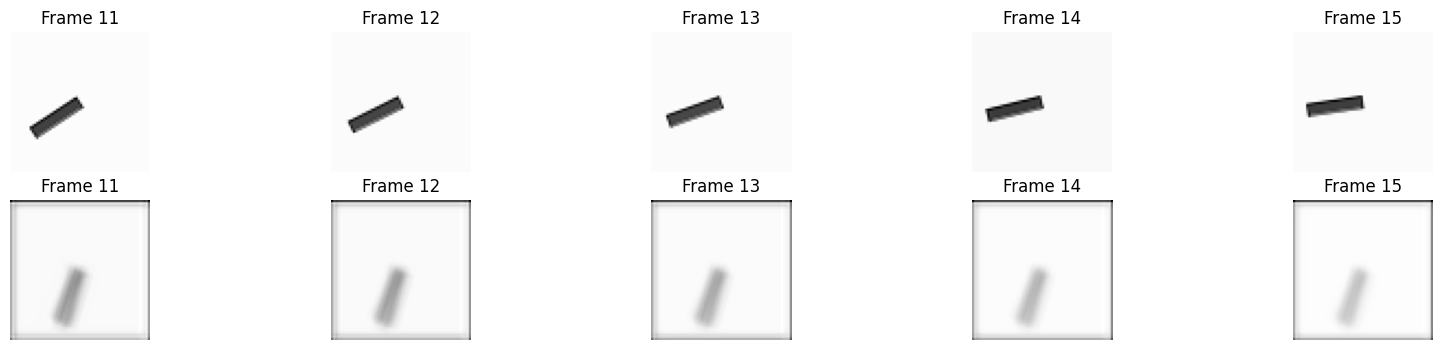

1/1 [==============================] - 0s 32ms/step


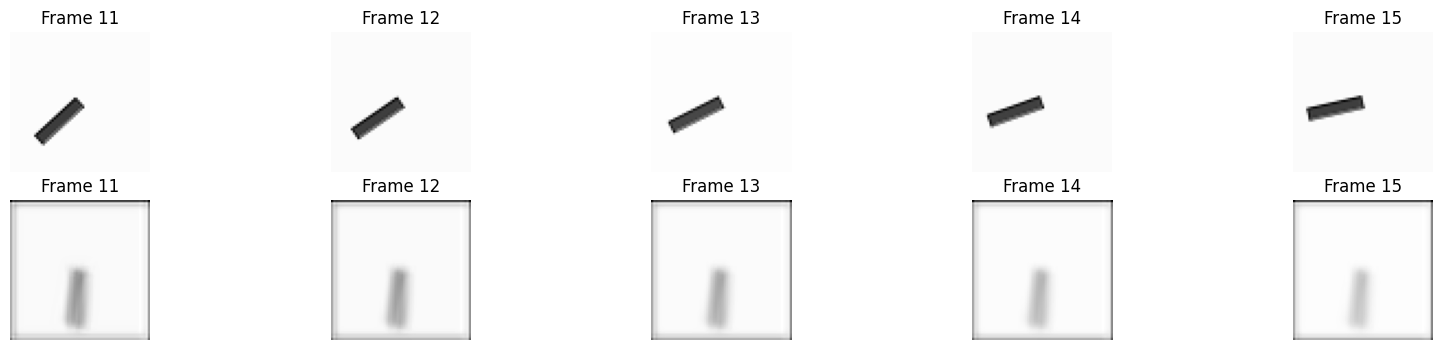

1/1 [==============================] - 0s 36ms/step


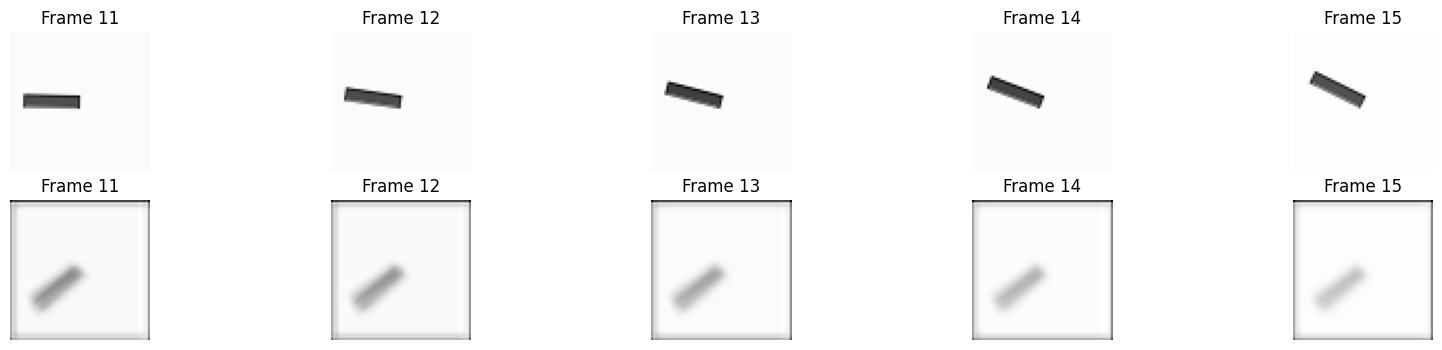

1/1 [==============================] - 0s 33ms/step


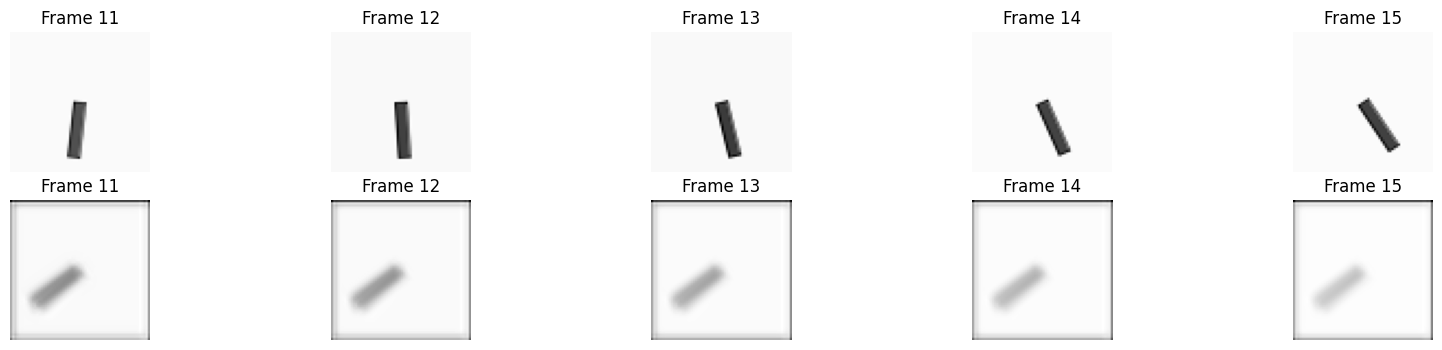

1/1 [==============================] - 0s 32ms/step


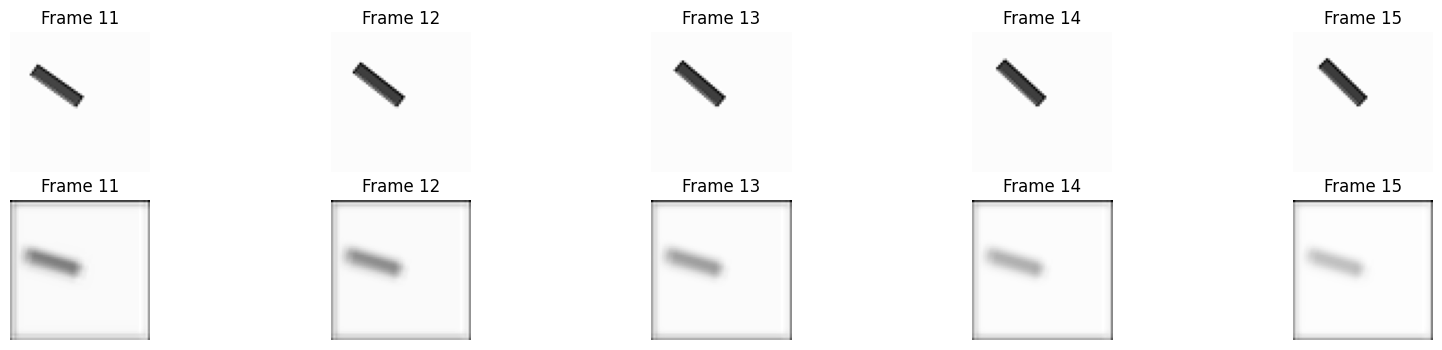

1/1 [==============================] - 0s 32ms/step


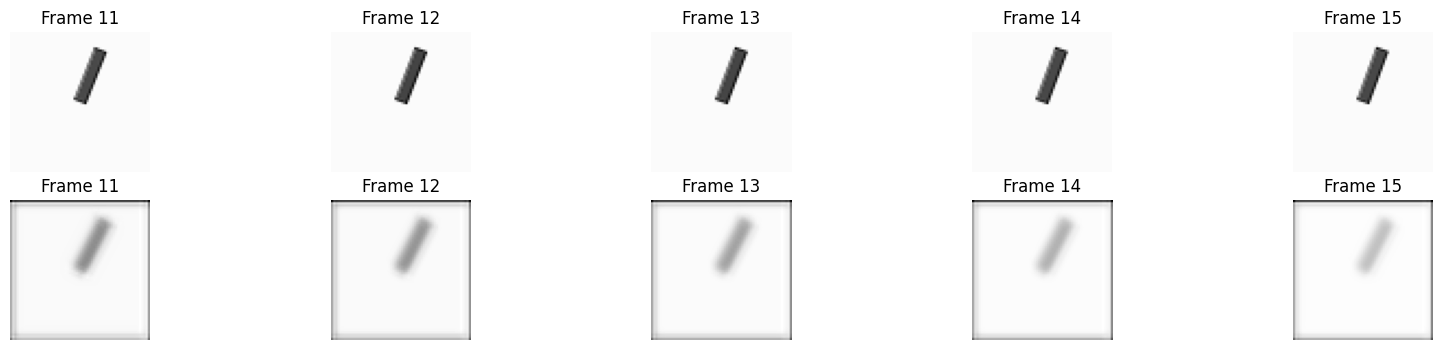

1/1 [==============================] - 0s 32ms/step


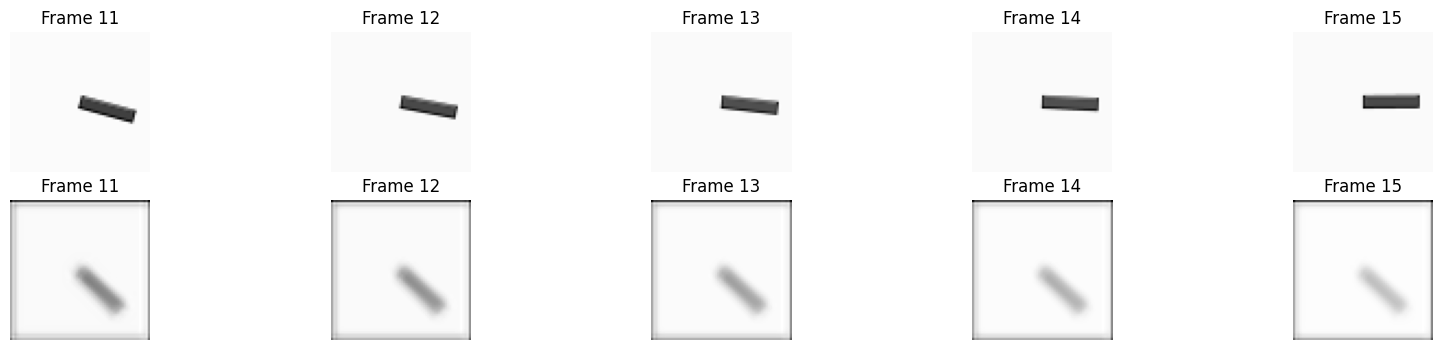

In [19]:
#V2 Code images

import random
for i in range(30):
    # Select a random example from the validation dataset.
    example = train_dataset[random.randrange(101,499)]

    # Pick the first/last ten frames from the example.
    frames = example[:5, ...]
    original_frames = example[5:, ...]

    # Predict a new set of 10 frames.
    for _ in range(5):
        # Extract the model's prediction and post-process it.
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        frames = np.concatenate((frames, predicted_frame), axis=0)

    # Construct a figure for the original and new frames.
    fig, axes = plt.subplots(2, 5, figsize=(20, 4))

    # Plot the original frames.
    for idx, ax in enumerate(axes[0]):
        ax.imshow(original_frames[idx], cmap='gray')
        ax.set_title(f"Frame {idx + 11}")
        ax.axis("off")

    # Plot the new frames.
    new_frames = frames[5:, ...]
    for idx, ax in enumerate(axes[1]):
        ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
        ax.set_title(f"Frame {idx + 11}")
        ax.axis("off")

    # Display the figure.
    index=0
    plt.savefig("./r" + str(index) + ".png", bbox_inches="tight")
    index += 1
    plt.show()

1/1 [==============================] - 0s 64ms/step


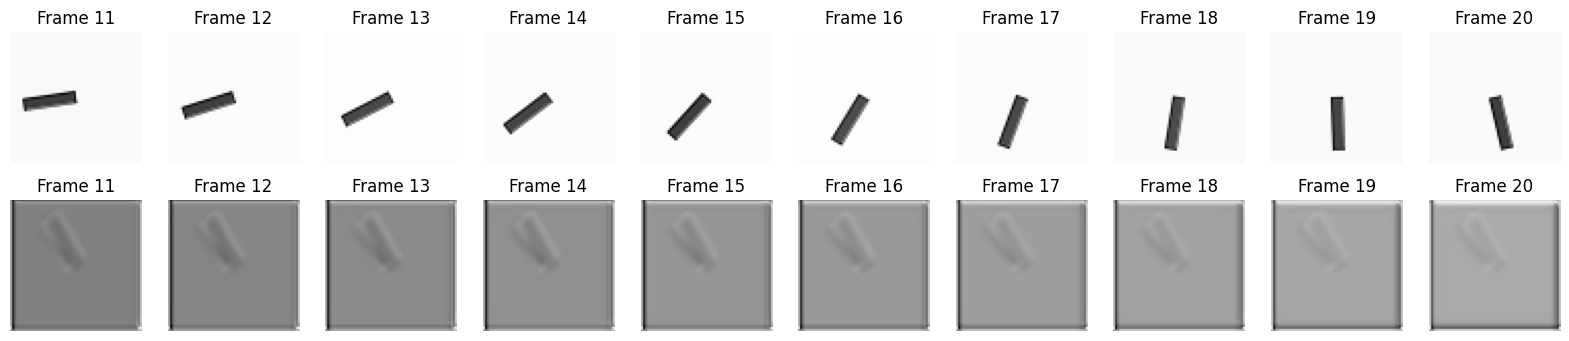

In [11]:
example = valid_dataset[np.random.choice(range(len(valid_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

PRE-TRAINED WEIGHTS

In [12]:
!pip install huggingface_hub["tensorflow"]

In [28]:
from huggingface_hub import from_pretrained_keras
model = from_pretrained_keras("keras-io/conv-lstm")

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 64, 64, 1   0         
                             )]                                  
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 64, 64, 64   416256    
                             )                                   
                                                                 
 batch_normalization (Batch  (None, None, 64, 64, 64   256       
 Normalization)              )                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 64, 64, 64   295168    
                             )                                   
                                                                 
 batch_normalization_1 (Bat  (None, None, 64, 64, 64   256   

In [30]:
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

data_dir = "/tmp/single_pendulum/"

num_train_folders = 300
num_val_folders = 40
num_test_folders = 40
img_size = 64
num_imgs = 40

def make_dataset(folder_list):
    img_array = []
    for folder_num in folder_list:
        folder = os.path.join(data_dir, str(folder_num))
        if os.path.isdir(folder):
            for img_num in range(num_imgs):  # change to 60 if can handle it
                img_path = os.path.join(folder, f'{img_num}.png')
                if os.path.isfile(img_path):
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, (img_size, img_size))
                    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    img_array.append(img_gray)
    img_array = np.array(img_array)
    img_array = img_array.reshape(len(folder_list), num_imgs, img_size, img_size, 1)
    return np.array(img_array) / 255.0

# Get a list of all folder names in the data directory
class_folders = [int(f) for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]

# Limit the number of folders for training, validation, and testing
train_folders, remaining_folders = train_test_split(class_folders, test_size=num_train_folders / len(class_folders), random_state=42)
val_test_folders, test_folders = train_test_split(remaining_folders, test_size=num_test_folders / len(remaining_folders), random_state=42)
val_folders, test_folders = train_test_split(val_test_folders, test_size=0.5, random_state=42)

train_dataset = make_dataset(train_folders[:num_train_folders])
valid_dataset = make_dataset(val_folders[:num_val_folders])
test_dataset = make_dataset(test_folders[:num_test_folders])



In [31]:
def create_shifted_frames(dataset):
    x = dataset[:, 0 : dataset.shape[1] - 1, :, :] #excludes last frame
    y = dataset[:, 1 : dataset.shape[1], :, :] #excludes first frame (shifted over)
    return x, y

x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(valid_dataset)
x_test, y_test = create_shifted_frames(test_dataset)

print(x_train.shape)

(300, 39, 64, 64, 1)


In [32]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 10
batch_size = 1

freeze_until_layer = 'conv_lstm2d_1'
for layer in model.layers:
    layer.trainable = False  # freeze all layers
    if layer.name == freeze_until_layer:
        break  # stop freezing layers once reach the specified layer

# model.compile(optimizer=model.optimizer, loss=model.loss)

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)


Epoch 1/10
300/300 [==============================] - 73s 232ms/step - loss: 0.8268 - val_loss: 0.5634 - lr: 0.0010
Epoch 2/10
300/300 [==============================] - 69s 229ms/step - loss: 0.5206 - val_loss: 0.5535 - lr: 0.0010
Epoch 3/10
300/300 [==============================] - 69s 231ms/step - loss: 0.5164 - val_loss: 0.5480 - lr: 0.0010
Epoch 4/10
300/300 [==============================] - 69s 229ms/step - loss: 0.5133 - val_loss: 0.5444 - lr: 0.0010
Epoch 5/10
300/300 [==============================] - 69s 229ms/step - loss: 0.5109 - val_loss: 0.5361 - lr: 0.0010
Epoch 6/10
300/300 [==============================] - 69s 229ms/step - loss: 0.5099 - val_loss: 0.5328 - lr: 0.0010
Epoch 7/10
300/300 [==============================] - 69s 229ms/step - loss: 0.5117 - val_loss: 0.5535 - lr: 0.0010
Epoch 8/10
300/300 [==============================] - 69s 231ms/step - loss: 0.5109 - val_loss: 0.5401 - lr: 0.0010
Epoch 9/10
300/300 [==============================] - 69s 230ms/step - l

In [18]:
model.save('/model_pretrain.keras')

In [19]:
# # Define some callbacks to improve training.
# early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# # Define modifiable training hyperparameters.
# epochs = 15
# batch_size = 1

# freeze_until_layer = 'conv_lstm2d_2'
# for layer in model.layers:
#     layer.trainable = True  # freeze all layers
#     if layer.name == freeze_until_layer:
#         break  # stop freezing layers once reach the specified layer

# # model.compile(optimizer=model.optimizer, loss=model.loss)

# # Fit the model to the training data.
# model.fit(
#     x_train,
#     y_train,
#     batch_size=batch_size,
#     epochs=epochs,
#     validation_data=(x_val, y_val),
#     callbacks=[early_stopping, reduce_lr],
# )


Epoch 1/15
400/400 [==============================] - 90s 226ms/step - loss: nan - val_loss: nan - lr: 1.0000e-04
Epoch 2/15
131/400 [========>.....................] - ETA: 59s - loss: nan 

KeyboardInterrupt: ignored

1/1 [==============================] - 0s 43ms/step


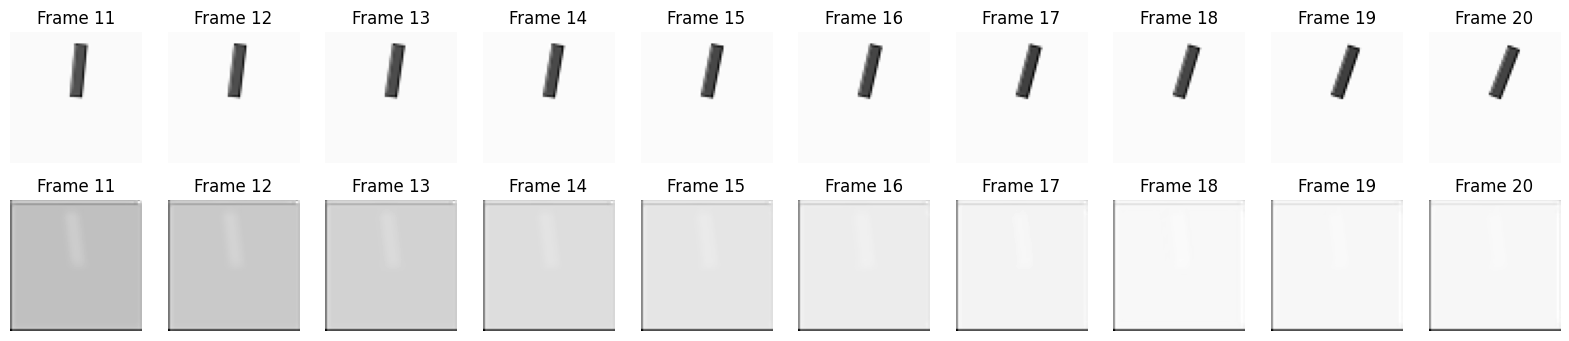

In [37]:
example = valid_dataset[np.random.choice(range(len(valid_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

LEELA

In [22]:
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import random_noise

n_samples = 500
n_frames = 30
row = 128
col = 128
dataset = np.zeros((n_samples, n_frames, row, col), dtype=float)

source_directory = "/tmp/single_pendulum"

for folder_num in range(n_samples):
    folder_path = source_directory + "/" + str(folder_num)
    if os.path.isdir(folder_path):
        for idx in range(n_frames):
            file_path = folder_path + "/" + str(idx) + ".png"
            img = cv2.imread(file_path)

            # Resize the image to 128x128
            img_resized = cv2.resize(img, (128, 128))

            # Convert the image to grayscale
            img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

            # Apply a threshold to create a binary mask
            _, binary_mask = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY)

            # Invert the binary mask
            inverted_mask = cv2.bitwise_not(binary_mask)

            # Set all pixels to 0 where the mask is black
            img_processed = cv2.bitwise_and(img_resized, img_resized, mask=inverted_mask)

            # Convert the processed image to grayscale
            img_normalized = cv2.cvtColor(img_processed, cv2.COLOR_BGR2GRAY)
            img_normalized = img_normalized / 255.0

            # Add salt and pepper noise
            # img_noisy = random_noise(img_normalized, mode='s&p', amount=0.2)

            # Normalize the pixel values to the range [0, 1]
            # img_noisy = img_noisy / 255.0

            # Assign the processed image to the dataset
            dataset[folder_num][idx] = img_normalized

In [23]:
dataset = dataset[..., np.newaxis]
dataset.shape

(500, 30, 128, 128, 1)

In [24]:
X = dataset[:, 0:n_frames-1, :, :]
y = dataset[:, 1:n_frames, :, :]

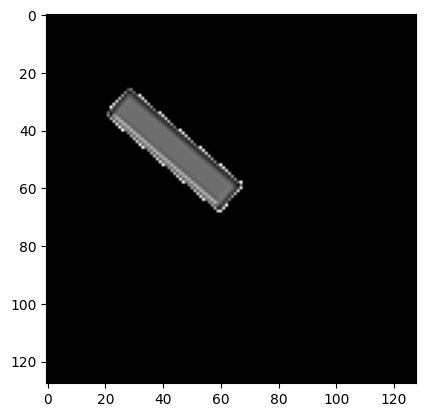

In [29]:
# Show example image
plt.imshow(dataset[0][0], cmap='gray')
plt.show()

In [26]:
from keras.layers import Attention, GlobalAveragePooling3D, concatenate, Reshape, Flatten

seq = Sequential()

seq.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                   input_shape=(None, 128, 128, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
# Add Attention Layer
# attention = Attention()
# conv_lstm_output = seq.get_layer(index=-2).output
# attention_result = attention([conv_lstm_output, conv_lstm_output])

# # Add Global Average Pooling
# pooled_attention = GlobalAveragePooling3D()(attention_result)
# # Flatten the conv_lstm_output
# flattened_conv_lstm = Flatten()(conv_lstm_output)

# # Reshape the attention output
# reshaped_attention = Reshape((1, 1, 64))(pooled_attention)

# # Flatten the reshaped_attention
# flattened_attention = Flatten()(reshaped_attention)

# # Concatenate the flattened original output and the flattened reshaped attention
# combined = concatenate([flattened_conv_lstm, flattened_attention])

# # Continue with the final Conv3D layer
# seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3), activation='sigmoid', padding='same', data_format='channels_last'))
# seq.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])


In [27]:
# Define some callbacks to improve training.


early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 3
batch_size = 1

# Fit the model to the training data.
# model.fit(
#     x_train,
#     y_train,
#     batch_size=batch_size,
#     epochs=epochs,
#     validation_data=(x_val, y_val),
#     callbacks=[early_stopping, reduce_lr],
# )

seq.fit(X[:300], y[:300], batch_size=1,
        epochs=epochs, validation_split=0.1,callbacks=[early_stopping, reduce_lr])

Epoch 1/3
270/270 [==============================] - 134s 469ms/step - loss: 0.1277 - accuracy: 0.9352 - val_loss: 2.3841 - val_accuracy: 0.8350 - lr: 0.0010
Epoch 2/3
270/270 [==============================] - 126s 466ms/step - loss: 0.0298 - accuracy: 0.9576 - val_loss: 0.0710 - val_accuracy: 0.9543 - lr: 0.0010
Epoch 3/3
270/270 [==============================] - 126s 467ms/step - loss: 0.0273 - accuracy: 0.9576 - val_loss: 0.0274 - val_accuracy: 0.9576 - lr: 0.0010


1/1 [==============================] - 0s 47ms/step


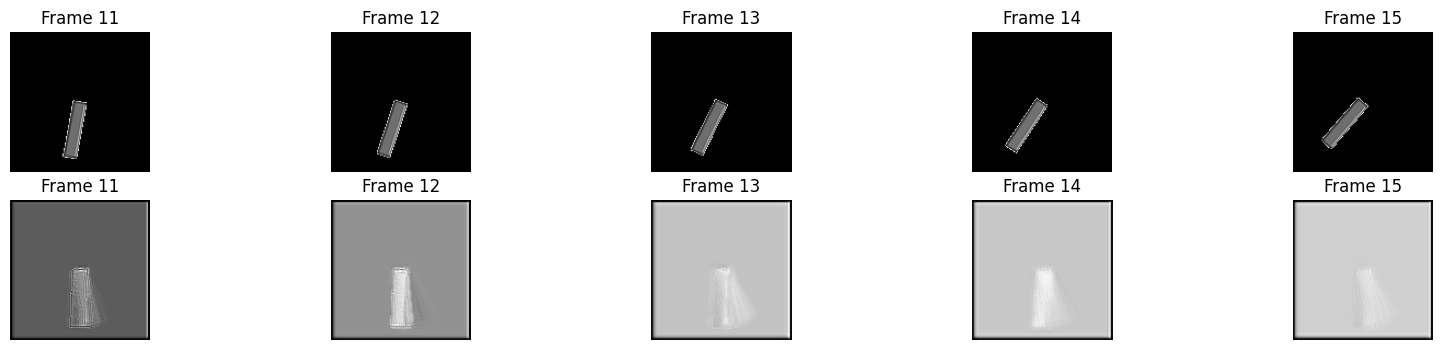

1/1 [==============================] - 0s 36ms/step


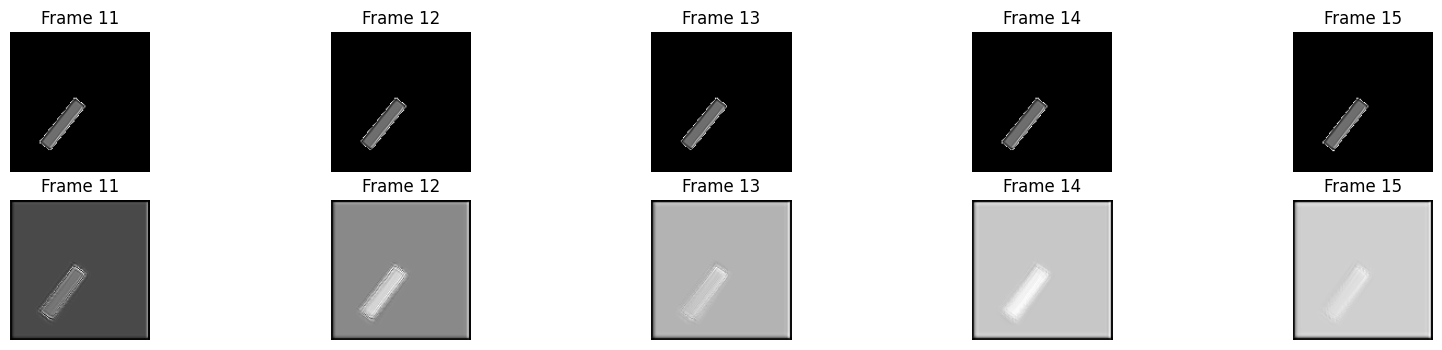

1/1 [==============================] - 0s 38ms/step


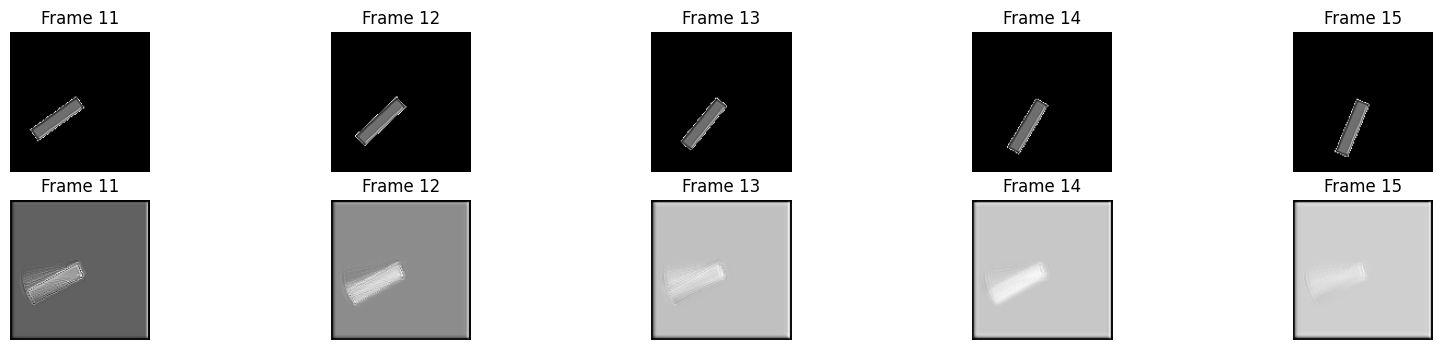

1/1 [==============================] - 0s 37ms/step


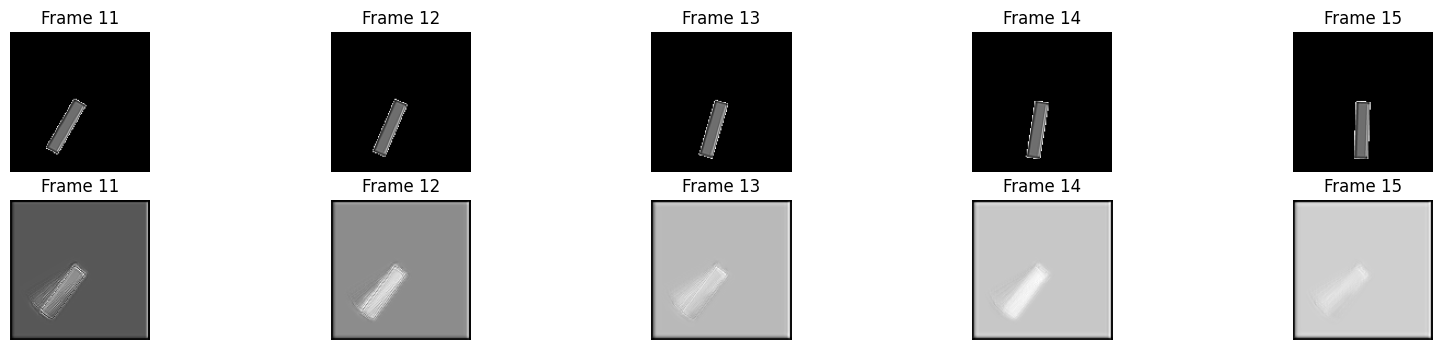

1/1 [==============================] - 0s 35ms/step


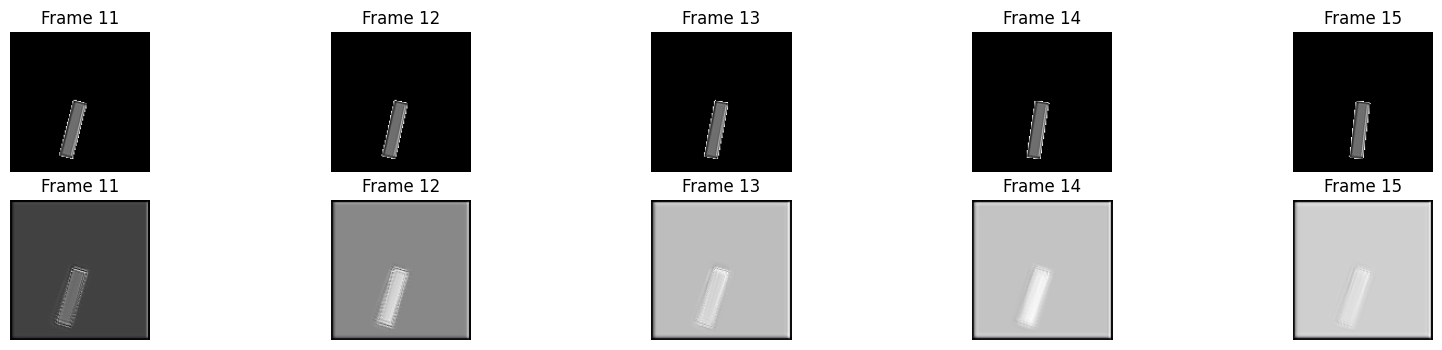

1/1 [==============================] - 0s 44ms/step


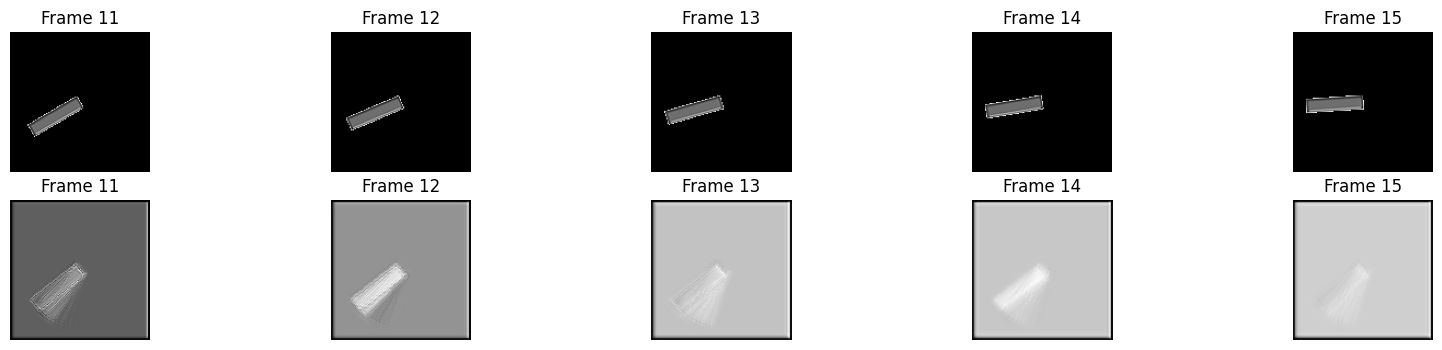

1/1 [==============================] - 0s 36ms/step


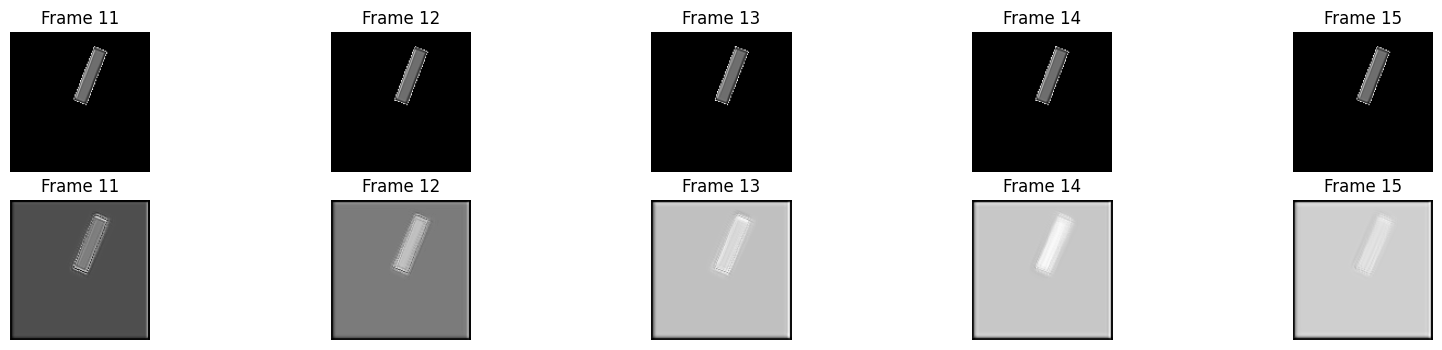

1/1 [==============================] - 0s 37ms/step


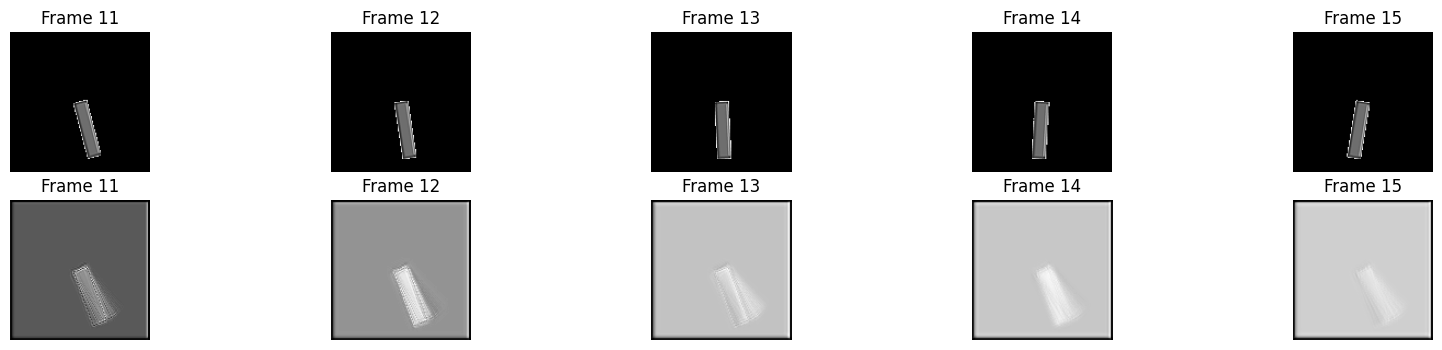

1/1 [==============================] - 0s 36ms/step


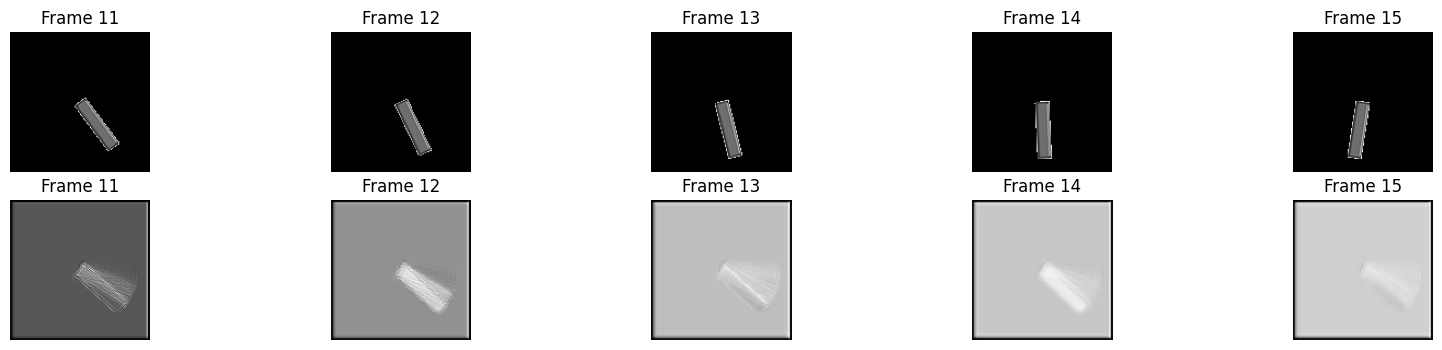

1/1 [==============================] - 0s 38ms/step


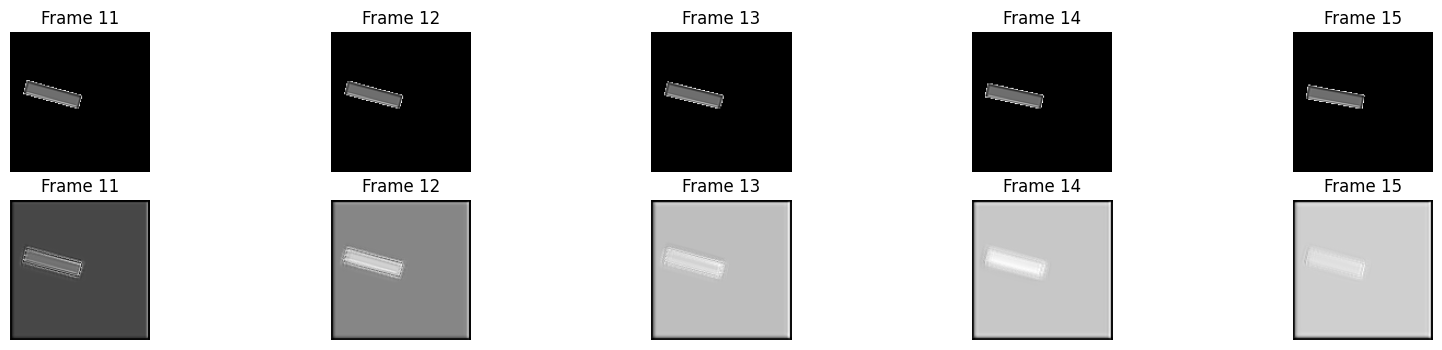

1/1 [==============================] - 0s 36ms/step


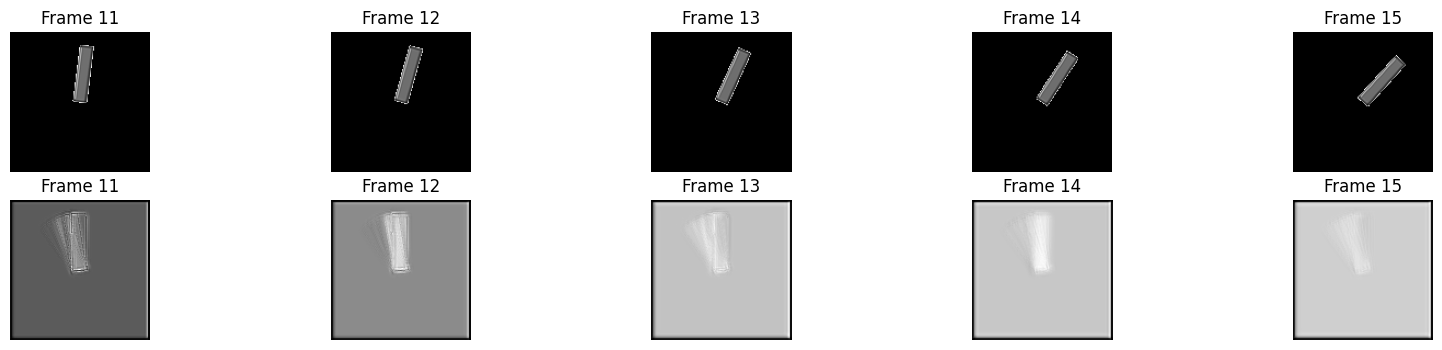

1/1 [==============================] - 0s 37ms/step


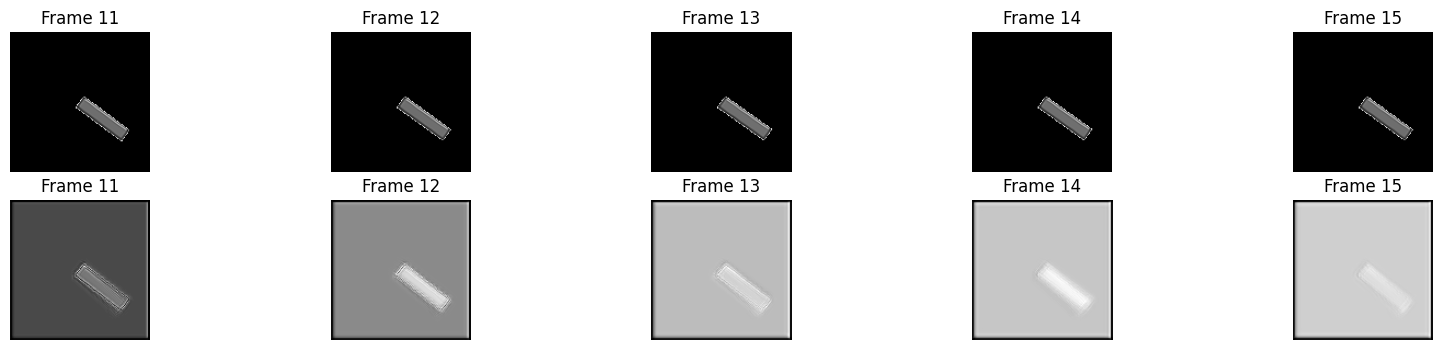

1/1 [==============================] - 0s 36ms/step


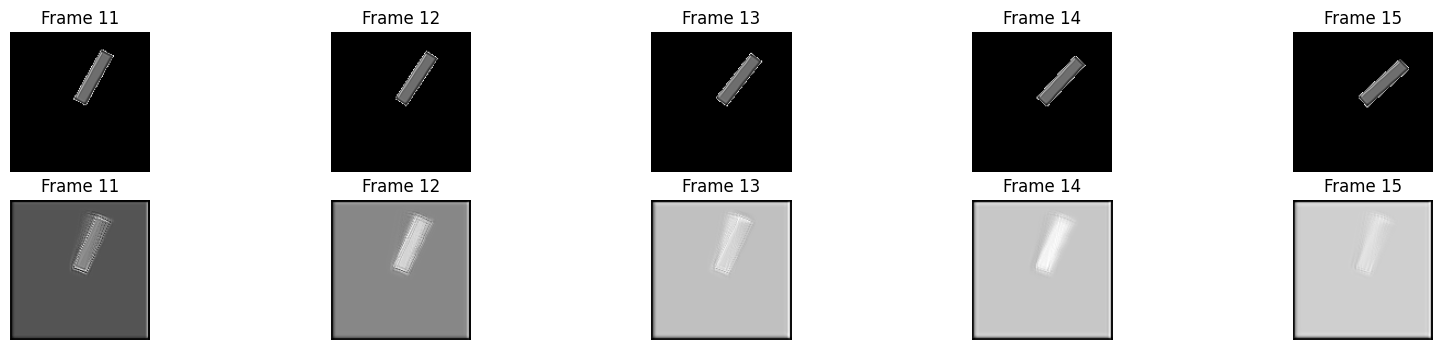

1/1 [==============================] - 0s 37ms/step


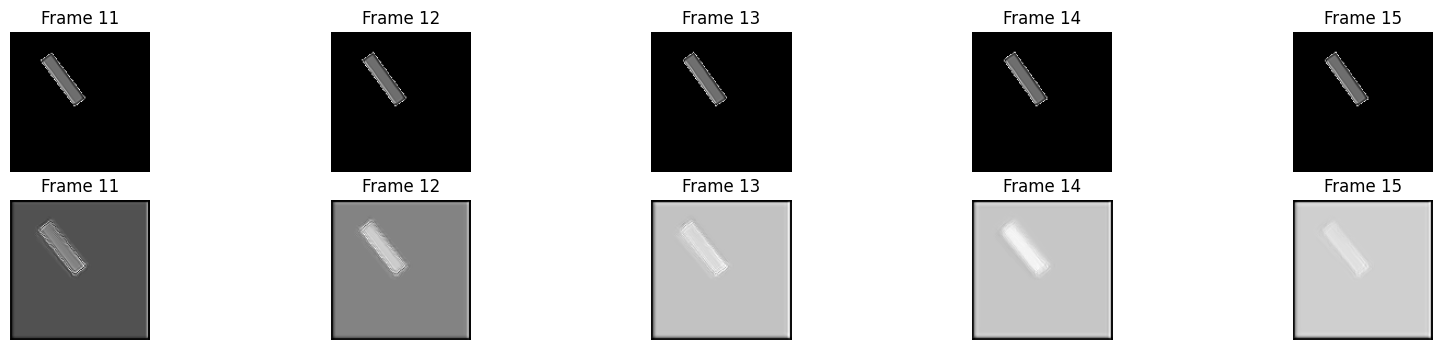

1/1 [==============================] - 0s 36ms/step


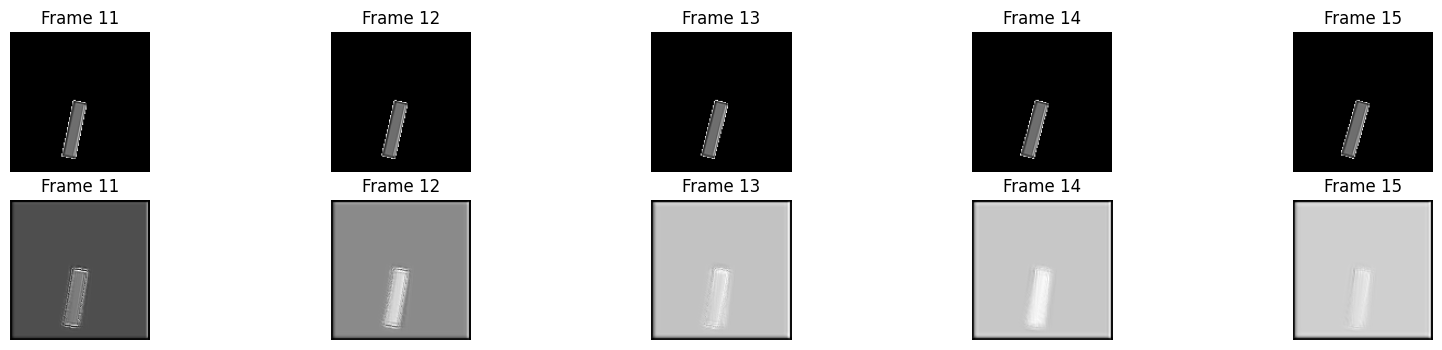

1/1 [==============================] - 0s 35ms/step


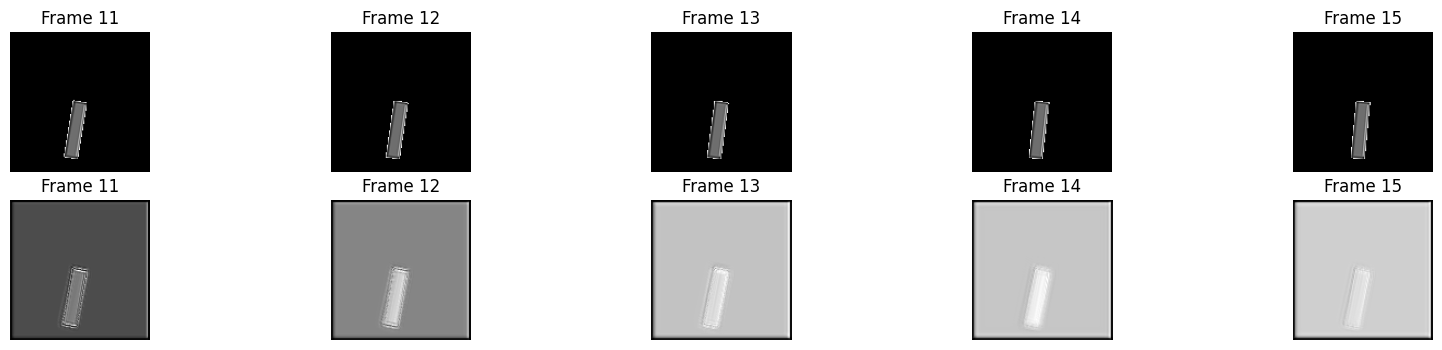

1/1 [==============================] - 0s 35ms/step


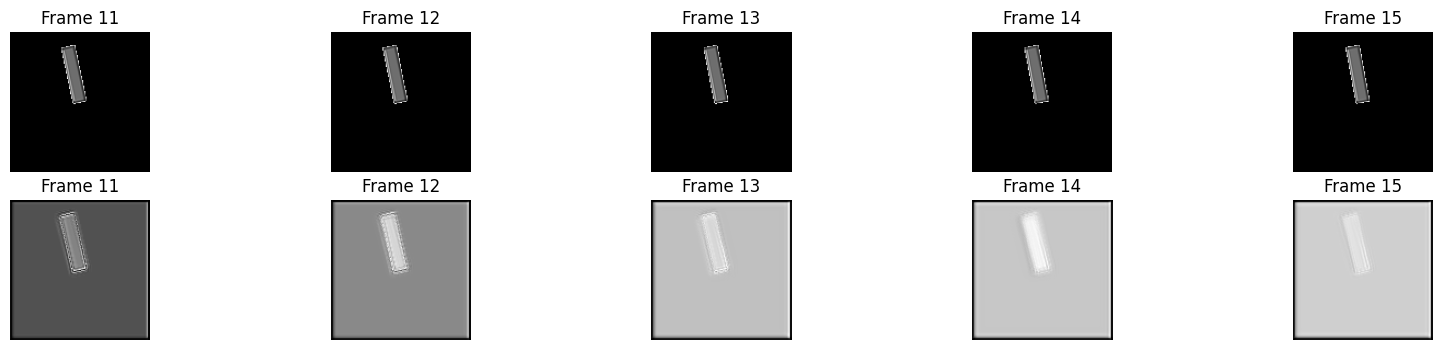

1/1 [==============================] - 0s 35ms/step


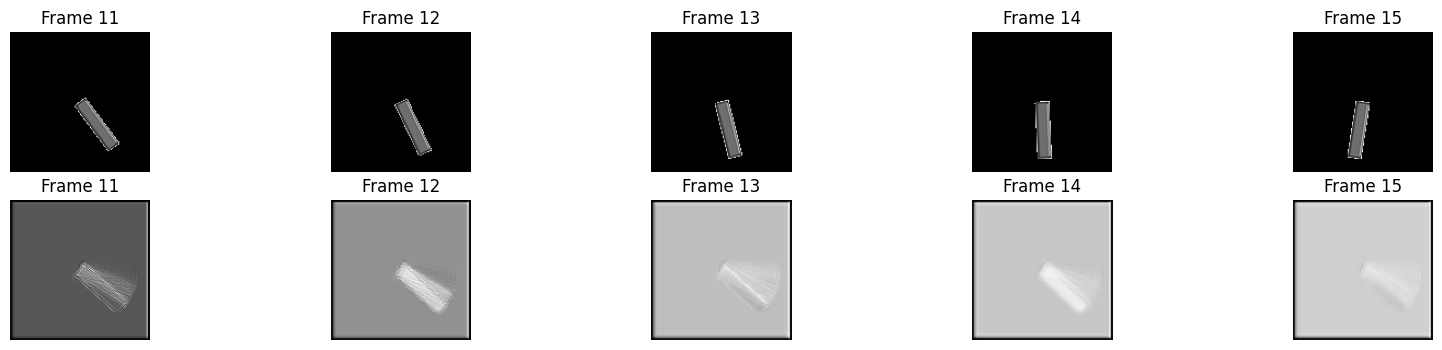

1/1 [==============================] - 0s 35ms/step


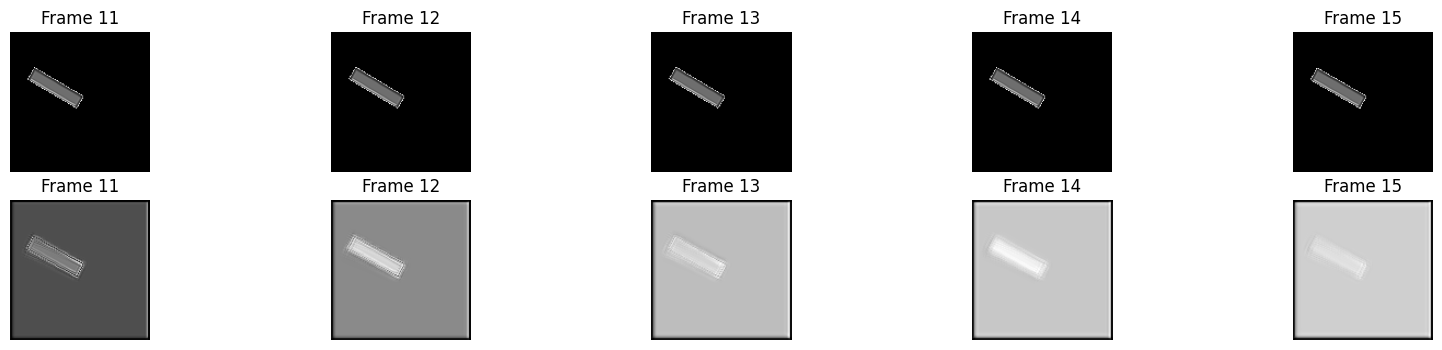

1/1 [==============================] - 0s 38ms/step


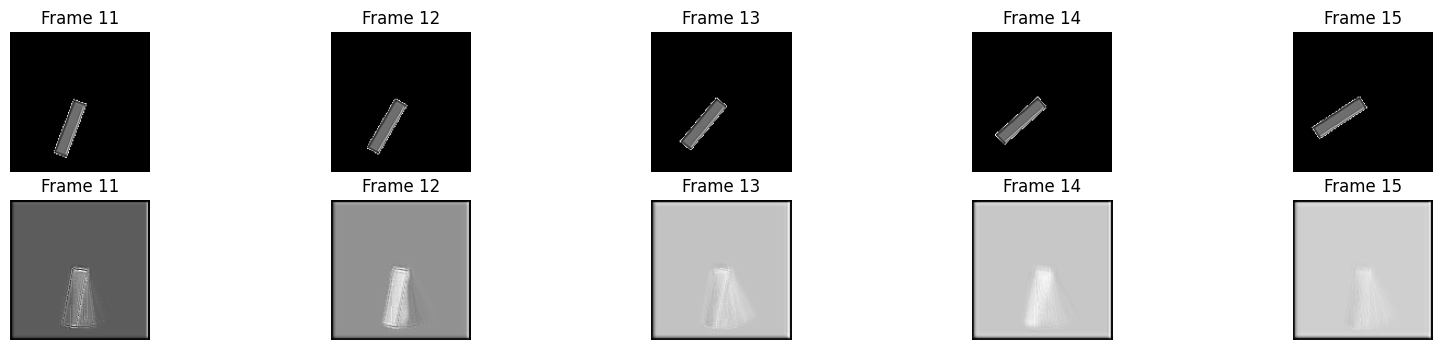

1/1 [==============================] - 0s 35ms/step


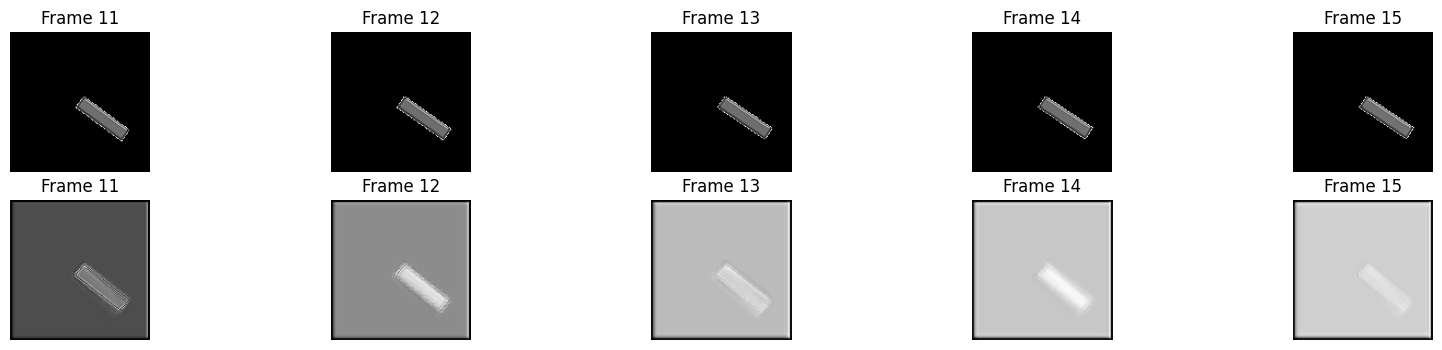

1/1 [==============================] - 0s 35ms/step


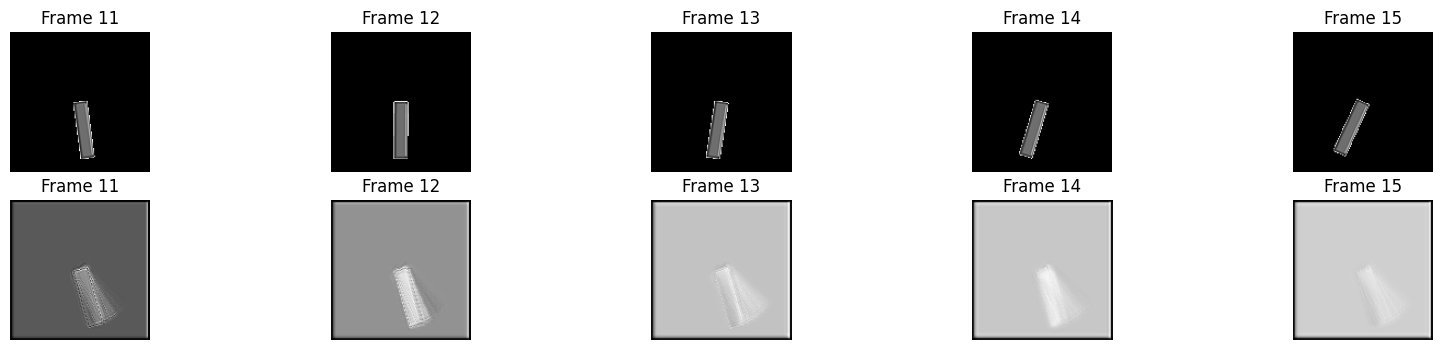

1/1 [==============================] - 0s 36ms/step


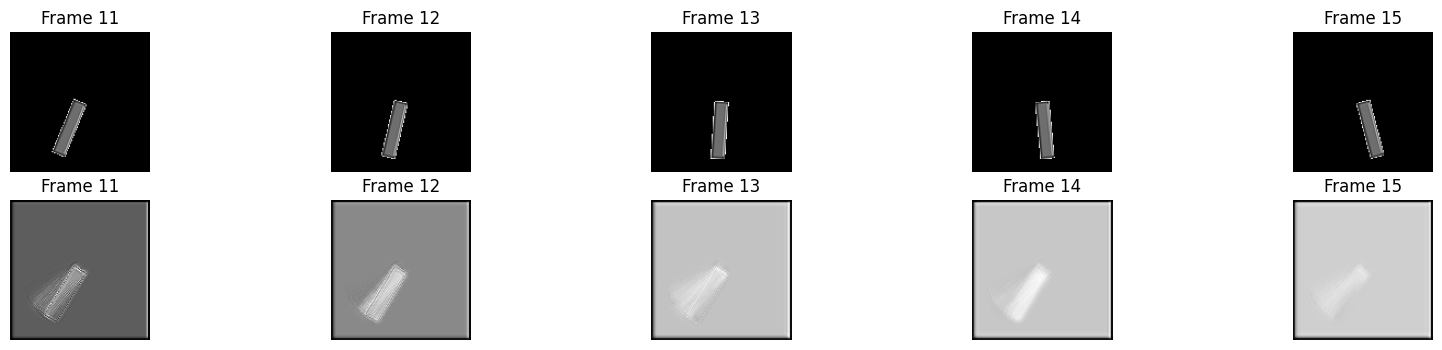

1/1 [==============================] - 0s 36ms/step


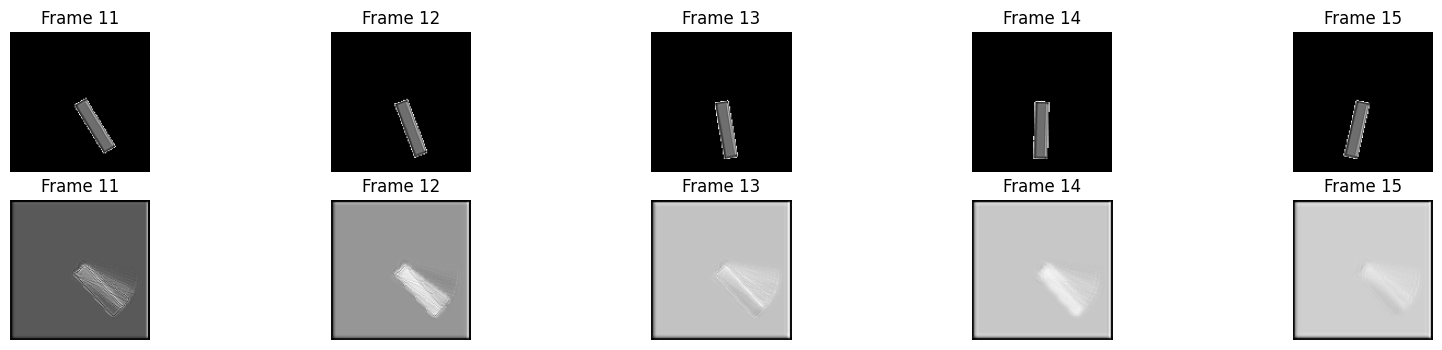

1/1 [==============================] - 0s 36ms/step


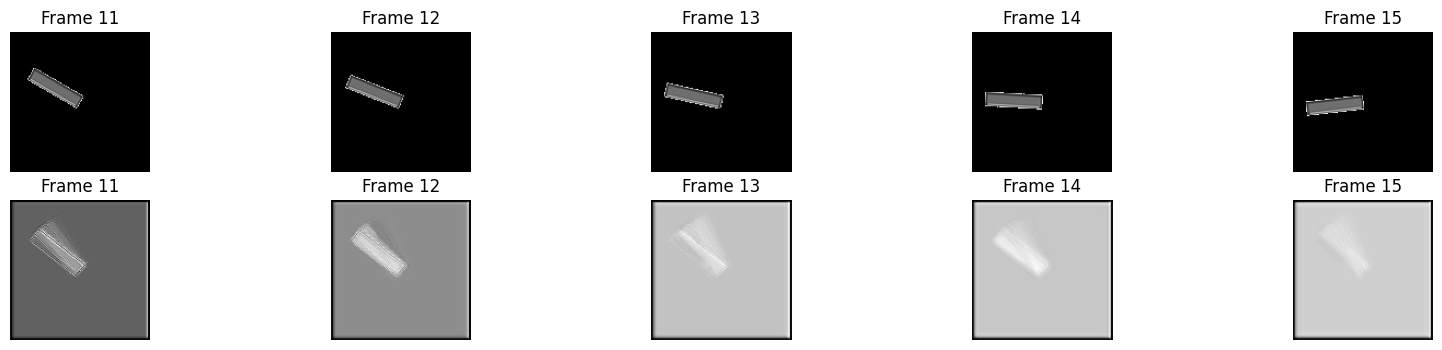

1/1 [==============================] - 0s 36ms/step


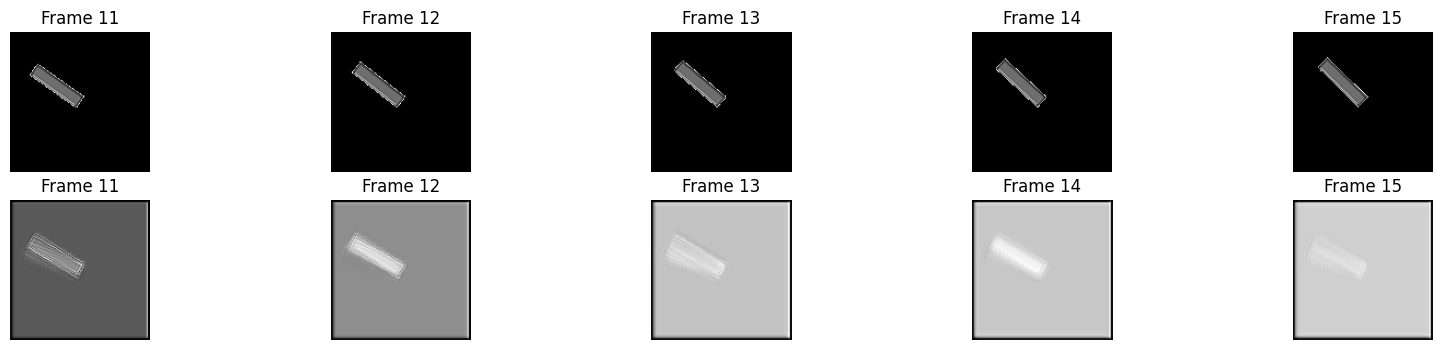

1/1 [==============================] - 0s 36ms/step


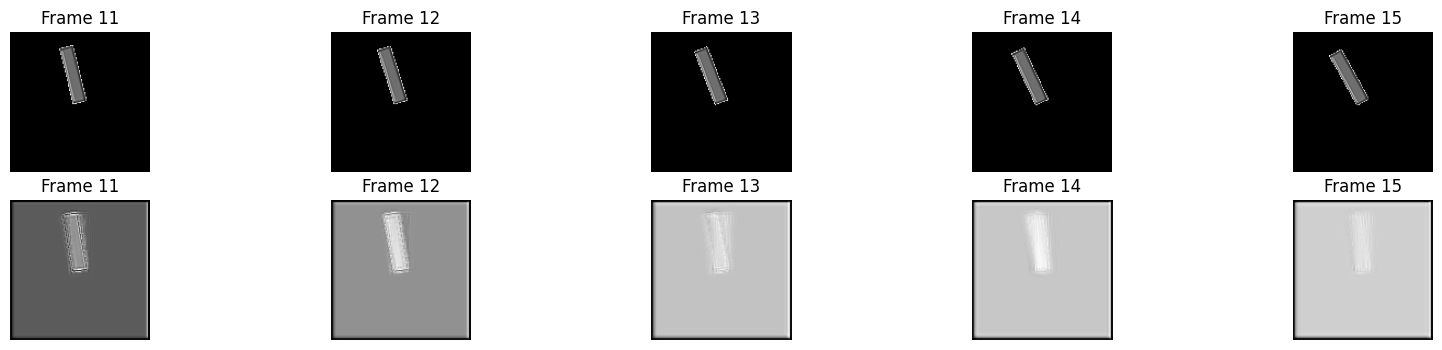

1/1 [==============================] - 0s 35ms/step


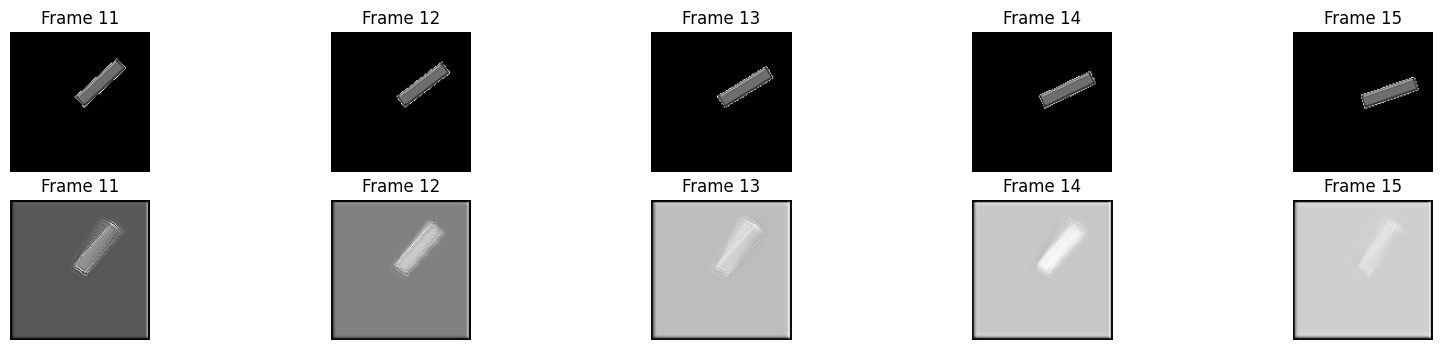

1/1 [==============================] - 0s 35ms/step


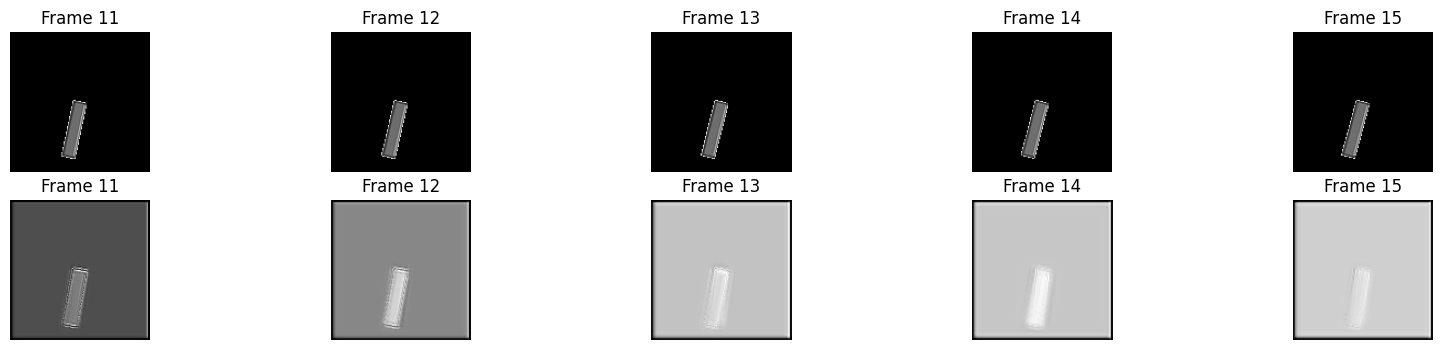

1/1 [==============================] - 0s 35ms/step


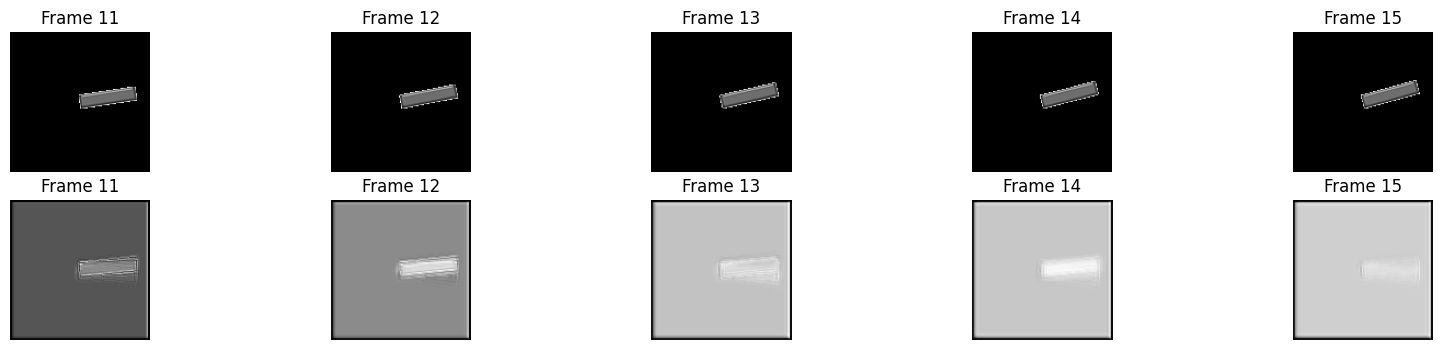

In [31]:
import random
# for 300 training
for i in range(30):
    # Select a random example from the validation dataset.
    example = dataset[random.randrange(300,499)]

    # Pick the first/last ten frames from the example.
    frames = example[:5, ...]
    original_frames = example[5:, ...]

    # Predict a new set of 10 frames.
    for _ in range(5):
        # Extract the model's prediction and post-process it.
        new_prediction = seq.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        frames = np.concatenate((frames, predicted_frame), axis=0)

    # Construct a figure for the original and new frames.
    fig, axes = plt.subplots(2, 5, figsize=(20, 4))

    # Plot the original frames.
    for idx, ax in enumerate(axes[0]):
        ax.imshow(original_frames[idx], cmap='gray')
        ax.set_title(f"Frame {idx + 11}")
        ax.axis("off")

    # Plot the new frames.
    new_frames = frames[5:, ...]
    for idx, ax in enumerate(axes[1]):
        ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
        ax.set_title(f"Frame {idx + 11}")
        ax.axis("off")

    # Display the figure.
    index=0
    # plt.savefig("./r" + str(index) + ".png", bbox_inches="tight")
    index += 1
    plt.show()

In [33]:
import random
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

# Create a PDF file to save the images
pdf_filename = "/output_frames_leela_v8.png"
pdf_pages = PdfPages(pdf_filename)

# for 300 training
for i in range(30):
    # Select a random example from the validation dataset.
    example = dataset[random.randrange(300, 499)]

    # Pick the first/last ten frames from the example.
    frames = example[:5, ...]
    original_frames = example[5:, ...]

    # Predict a new set of 10 frames.
    for _ in range(5):
        # Extract the model's prediction and post-process it.
        new_prediction = seq.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        frames = np.concatenate((frames, predicted_frame), axis=0)

    # Construct a figure for the original and new frames.
    fig, axes = plt.subplots(2, 5, figsize=(20, 4))

    # Plot the original frames.
    for idx, ax in enumerate(axes[0]):
        ax.imshow(original_frames[idx], cmap='gray')
        ax.set_title(f"Frame {idx + 11}")
        ax.axis("off")

    # Plot the new frames.
    new_frames = frames[5:, ...]
    for idx, ax in enumerate(axes[1]):
        ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
        ax.set_title(f"Frame {idx + 11}")
        ax.axis("off")

    # Save the figure to the PDF file
    pdf_pages.savefig(fig)
    plt.close()

# Close the PDF file
pdf_pages.close()
print(f"PDF saved to {pdf_filename}")

1/1 [==============================] - 0s 34ms/step
PDF saved to /output_frames_leela_v8.png


In [34]:
seq.save('/model_leela_v8.keras')

1/1 [==============================] - 0s 67ms/step


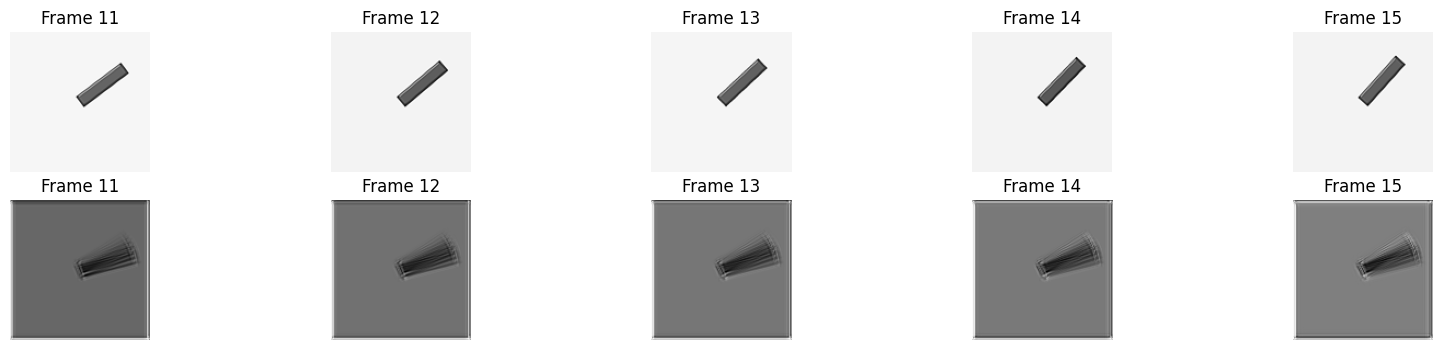

1/1 [==============================] - 0s 34ms/step


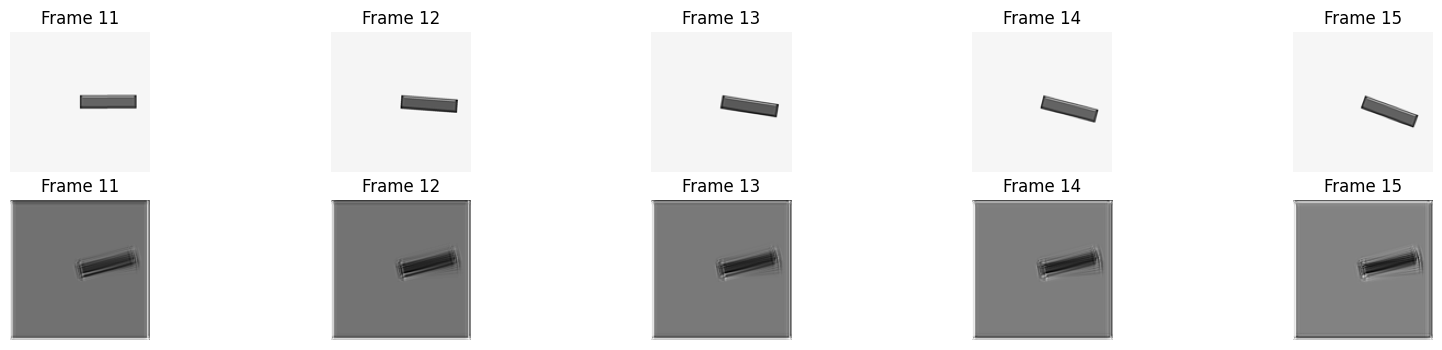

1/1 [==============================] - 0s 34ms/step


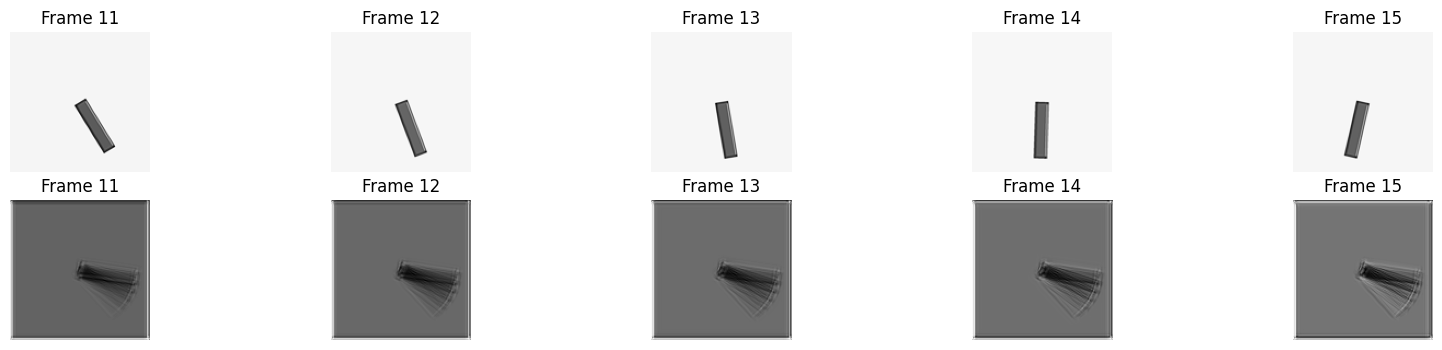

1/1 [==============================] - 0s 34ms/step


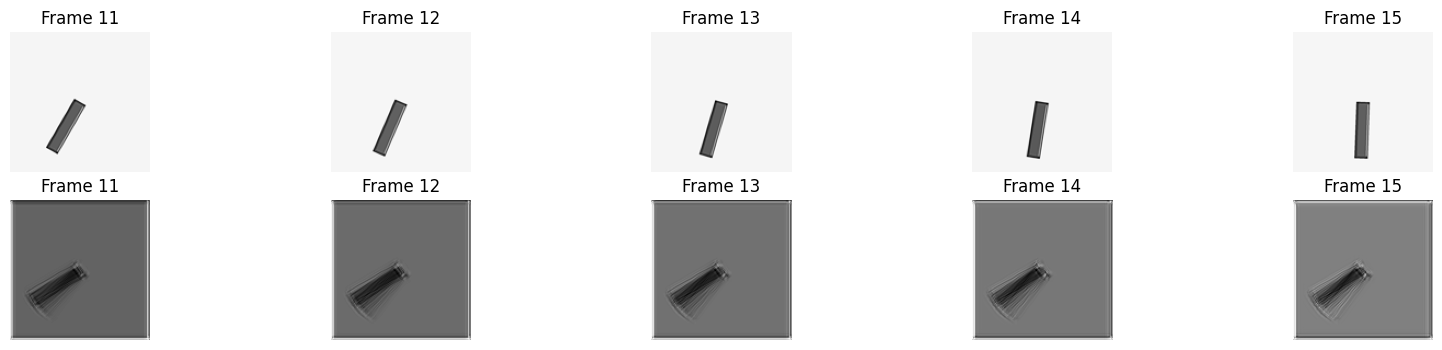

1/1 [==============================] - 0s 35ms/step


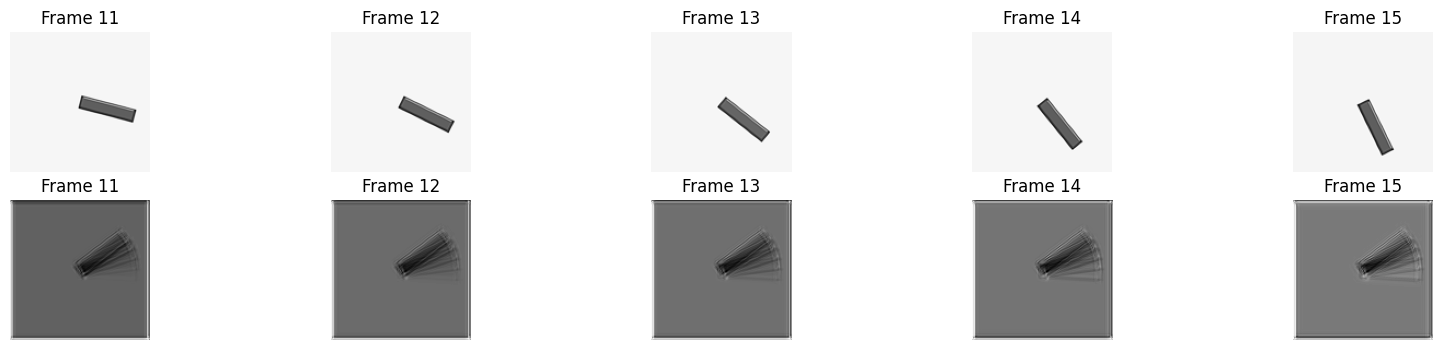

1/1 [==============================] - 0s 38ms/step


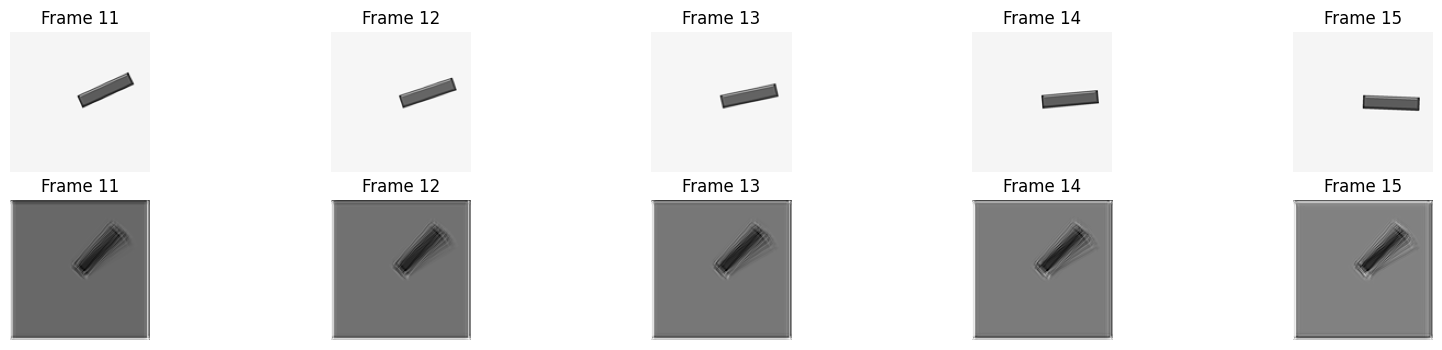

1/1 [==============================] - 0s 36ms/step


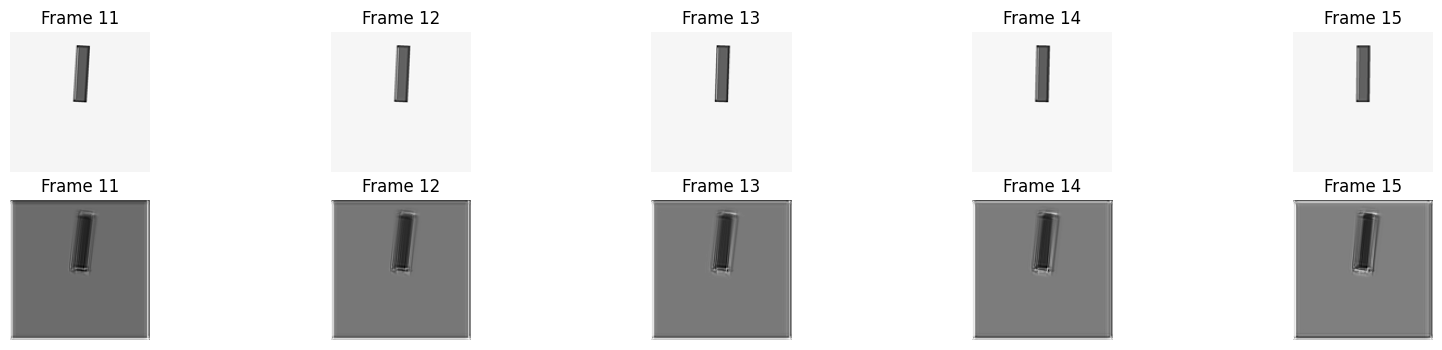

1/1 [==============================] - 0s 33ms/step


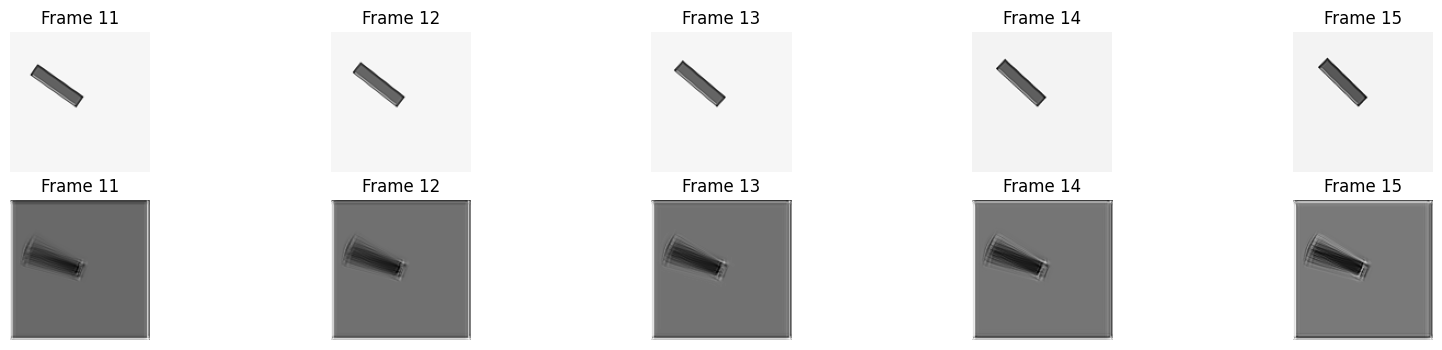

1/1 [==============================] - 0s 34ms/step


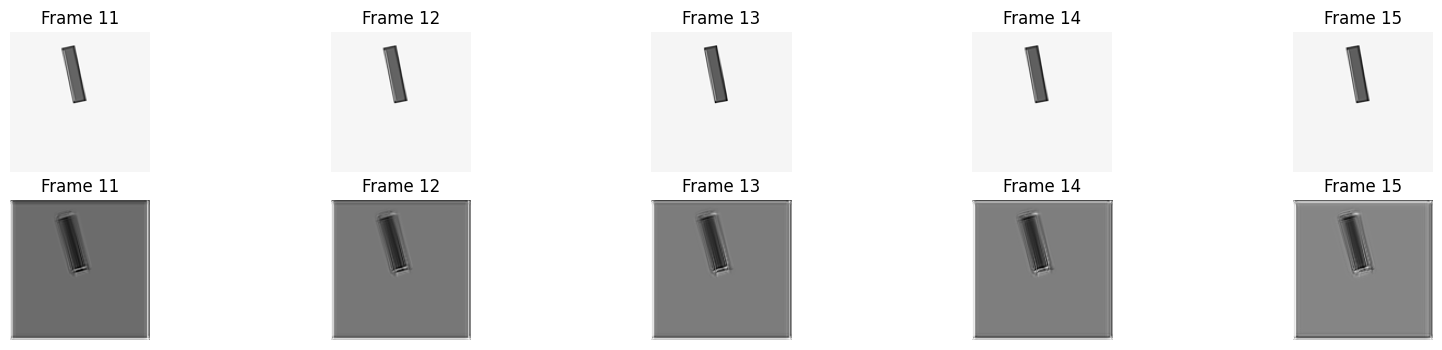

1/1 [==============================] - 0s 34ms/step


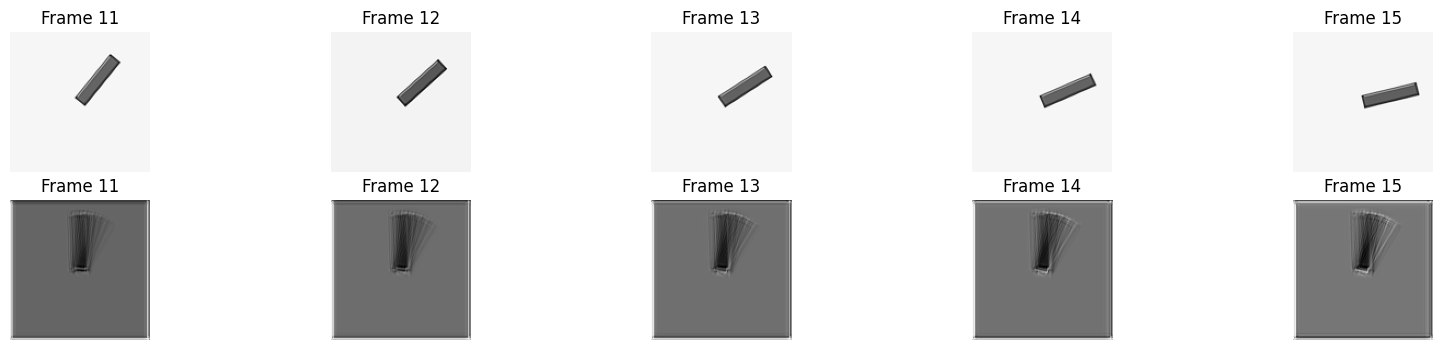

1/1 [==============================] - 0s 34ms/step


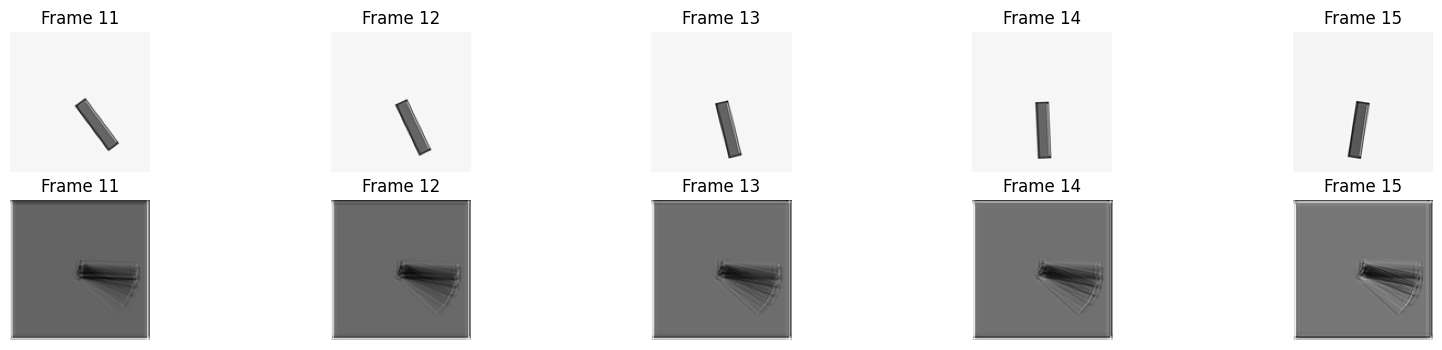

1/1 [==============================] - 0s 33ms/step


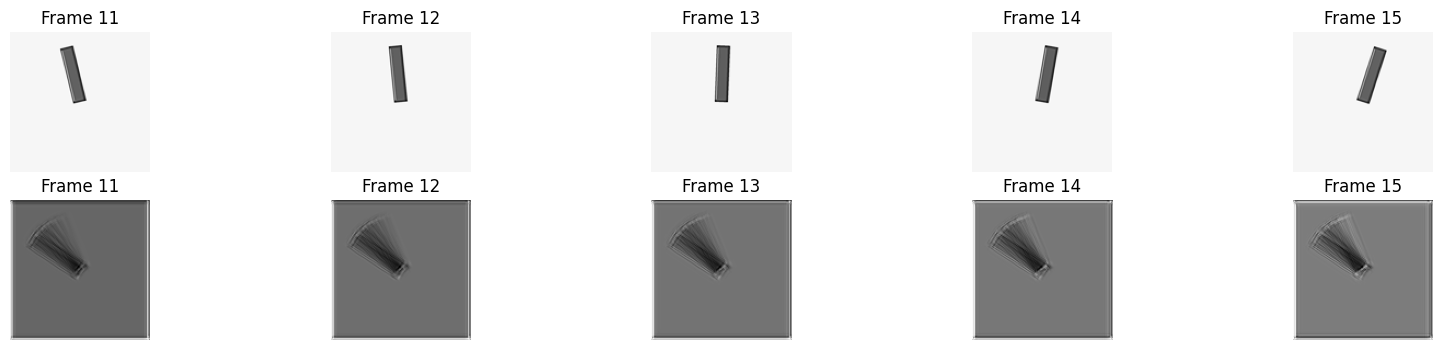

1/1 [==============================] - 0s 36ms/step


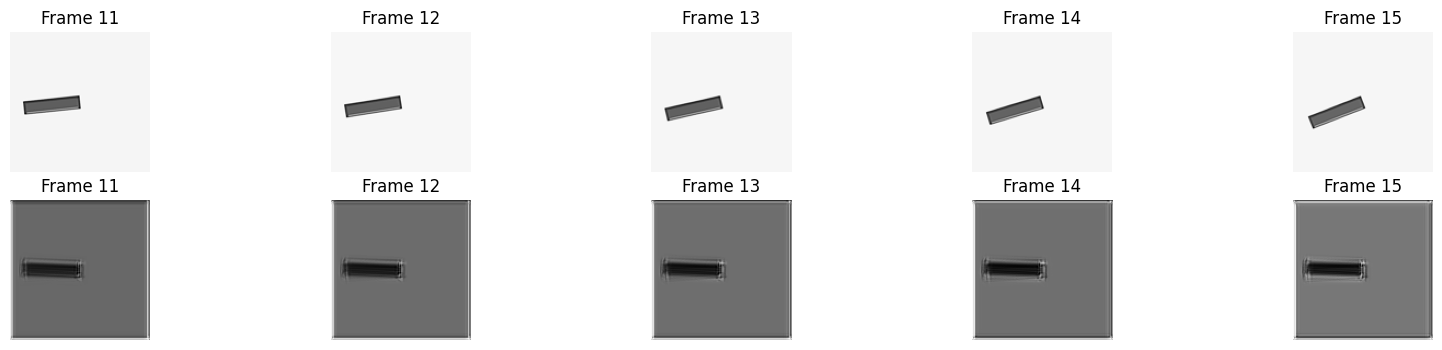

1/1 [==============================] - 0s 34ms/step


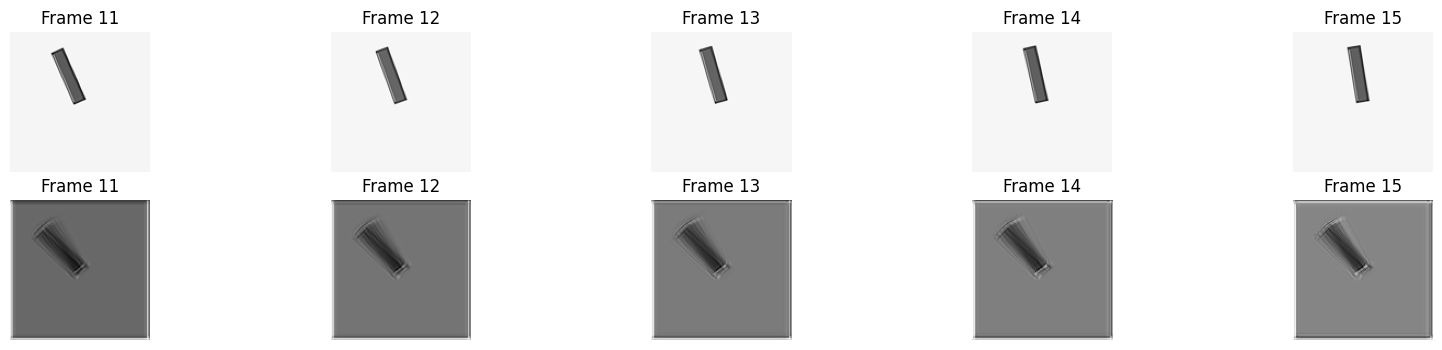

1/1 [==============================] - 0s 33ms/step


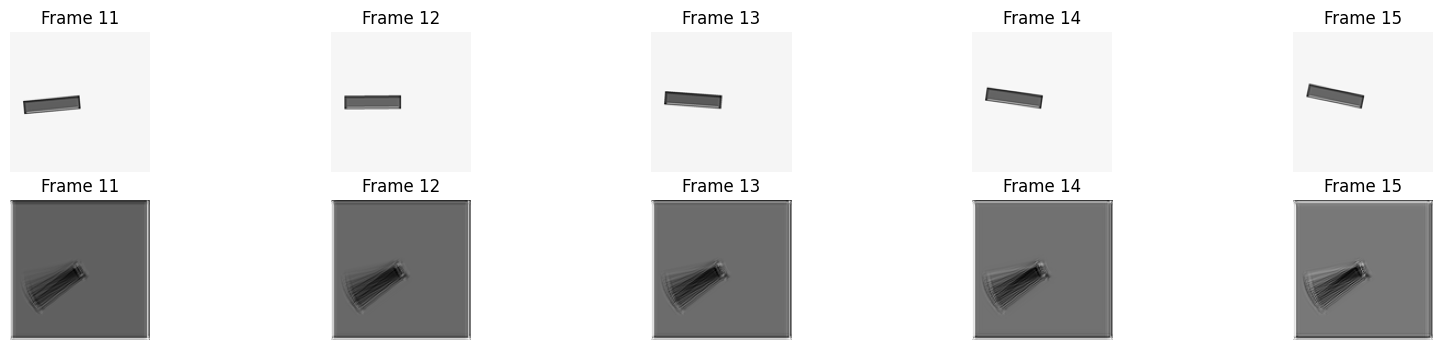

1/1 [==============================] - 0s 33ms/step


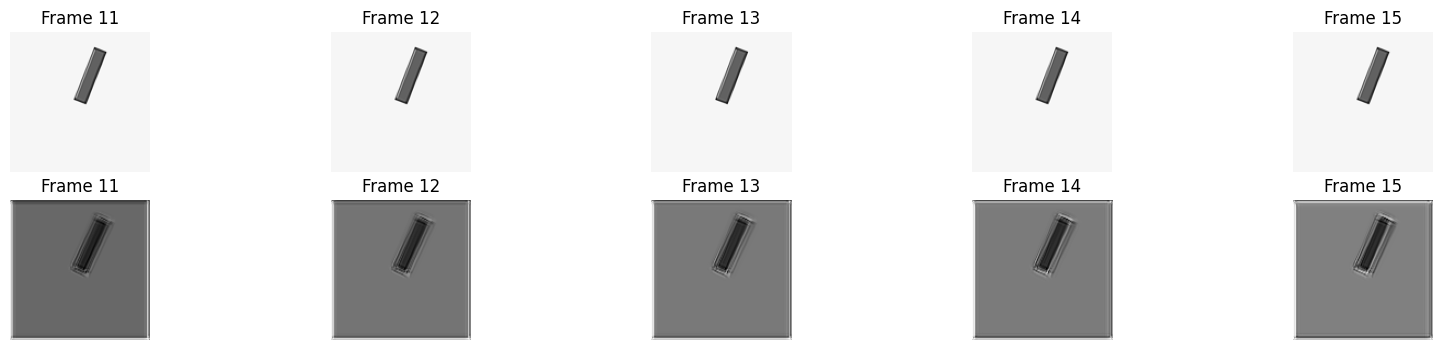

1/1 [==============================] - 0s 34ms/step


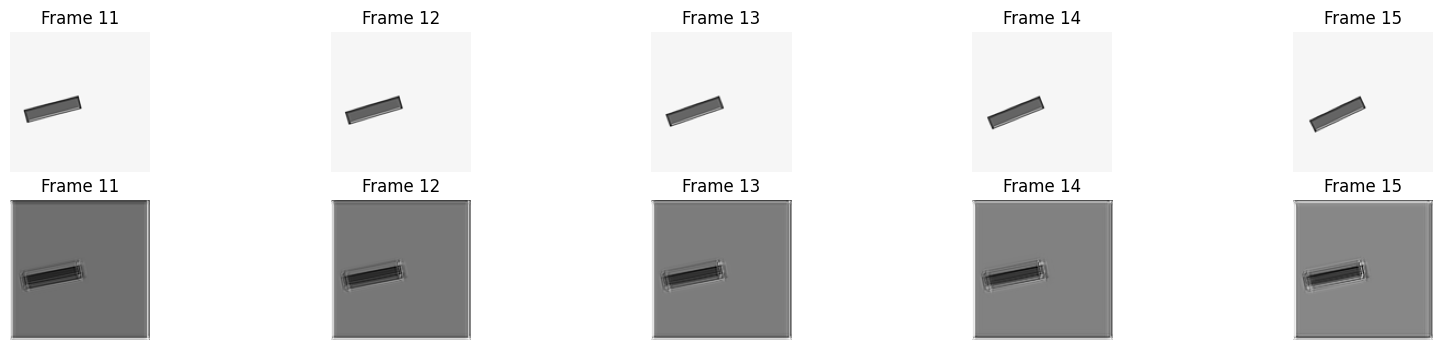

1/1 [==============================] - 0s 34ms/step


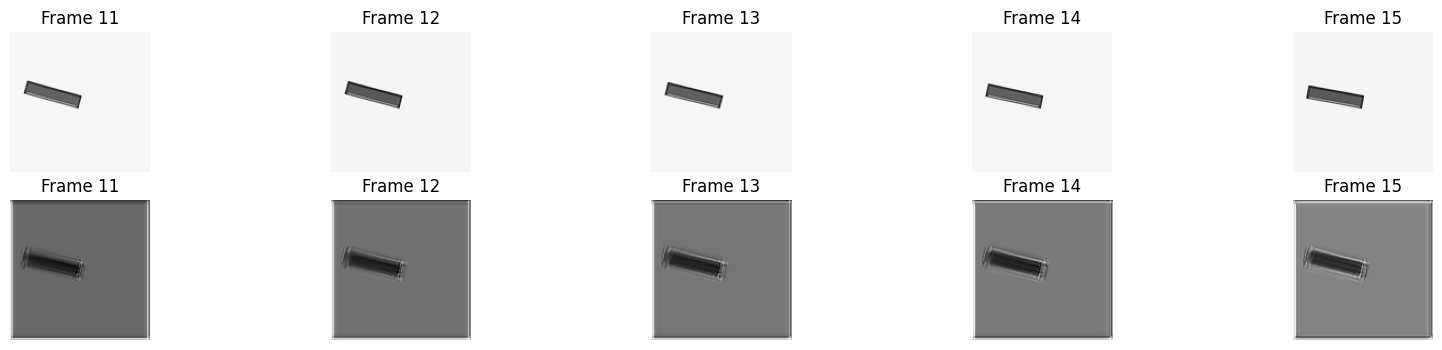

1/1 [==============================] - 0s 36ms/step


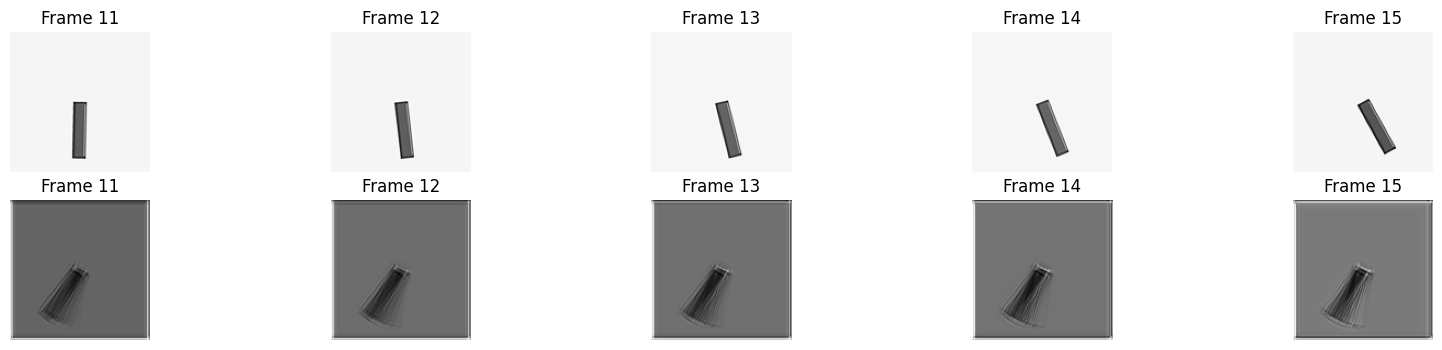

1/1 [==============================] - 0s 36ms/step


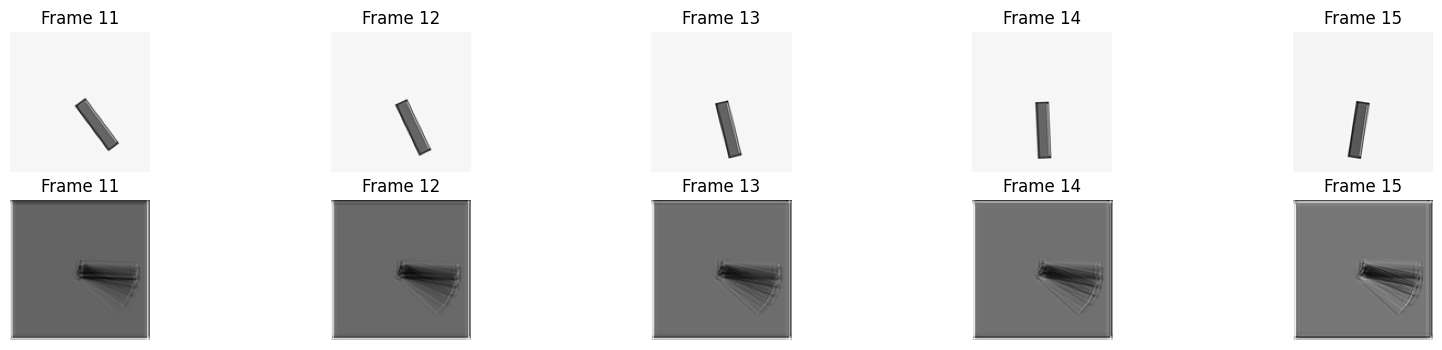

1/1 [==============================] - 0s 35ms/step


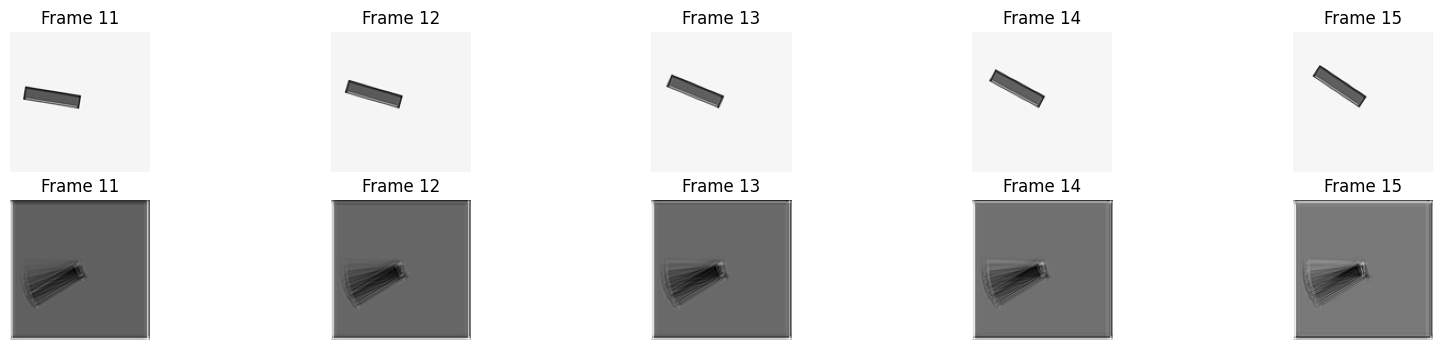

1/1 [==============================] - 0s 35ms/step


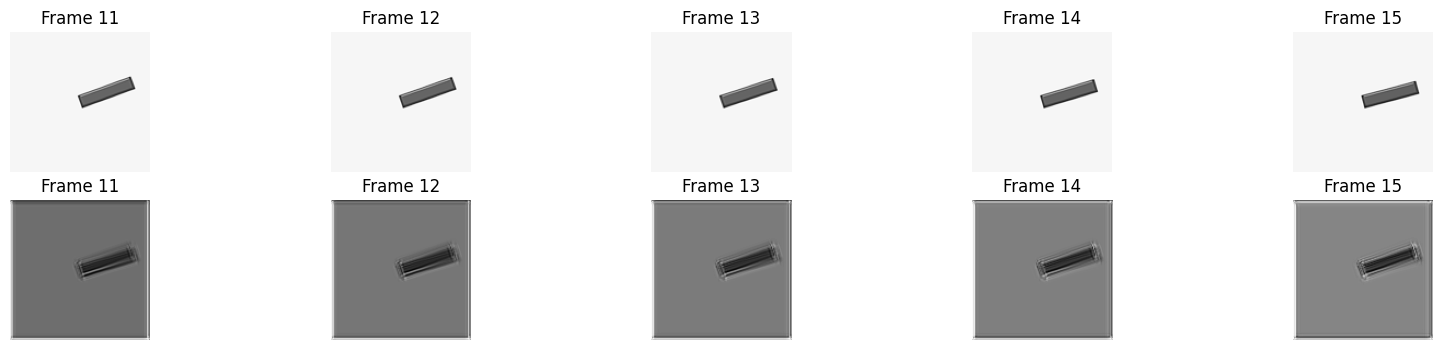

1/1 [==============================] - 0s 35ms/step


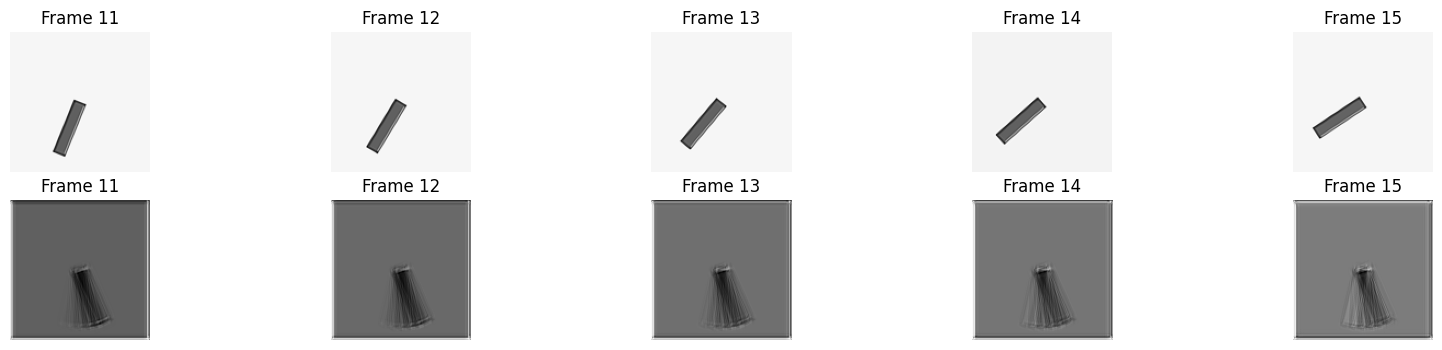

1/1 [==============================] - 0s 35ms/step


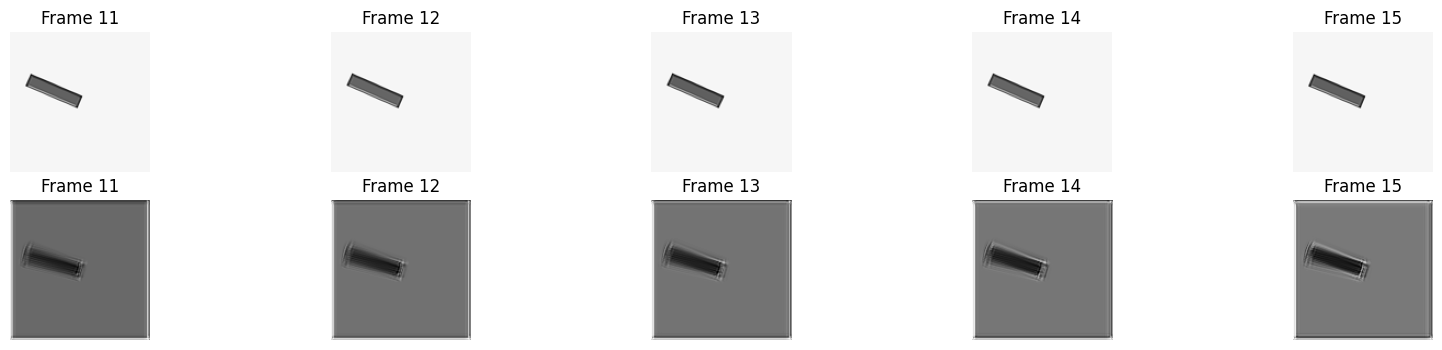

1/1 [==============================] - 0s 34ms/step


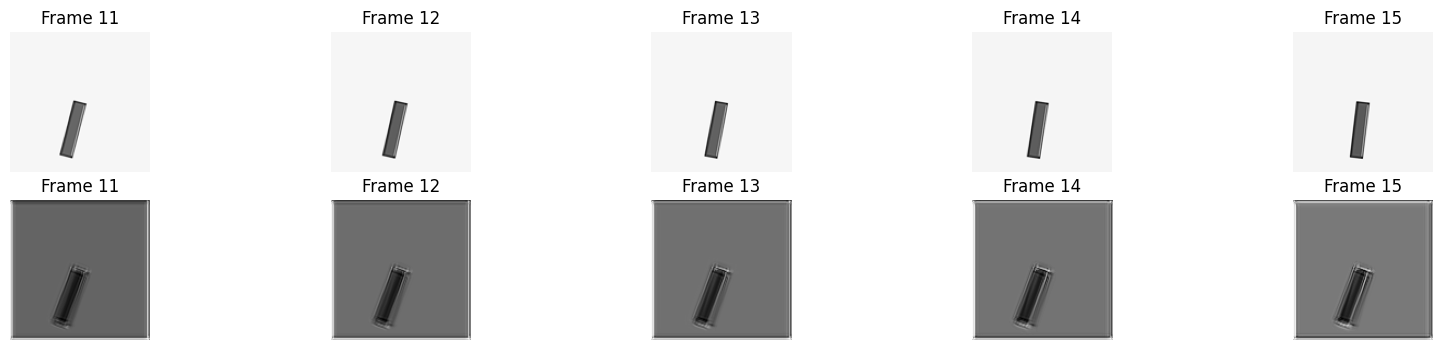

1/1 [==============================] - 0s 34ms/step


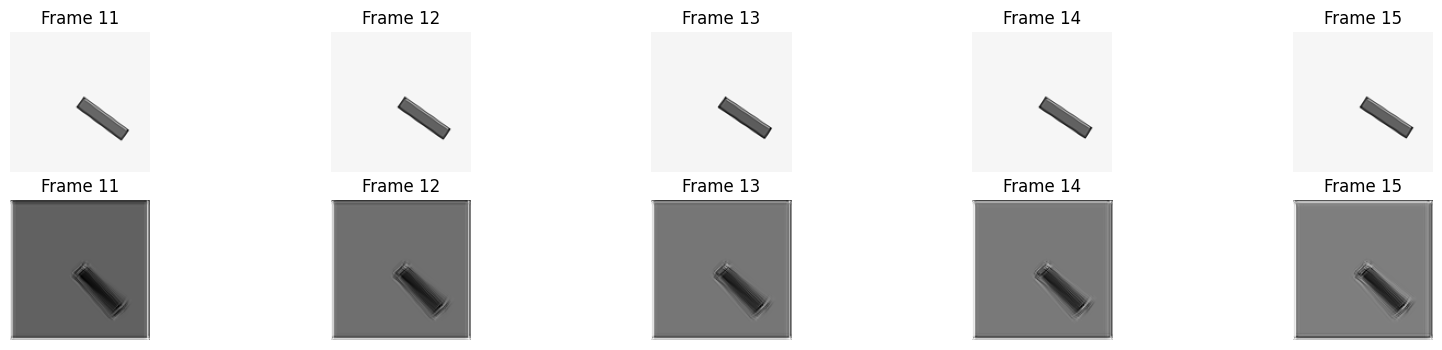

1/1 [==============================] - 0s 34ms/step


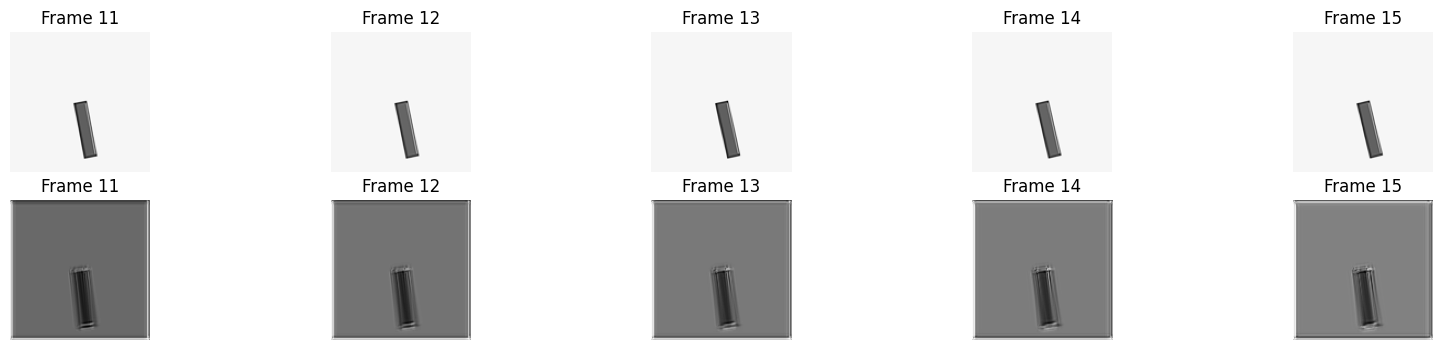

1/1 [==============================] - 0s 34ms/step


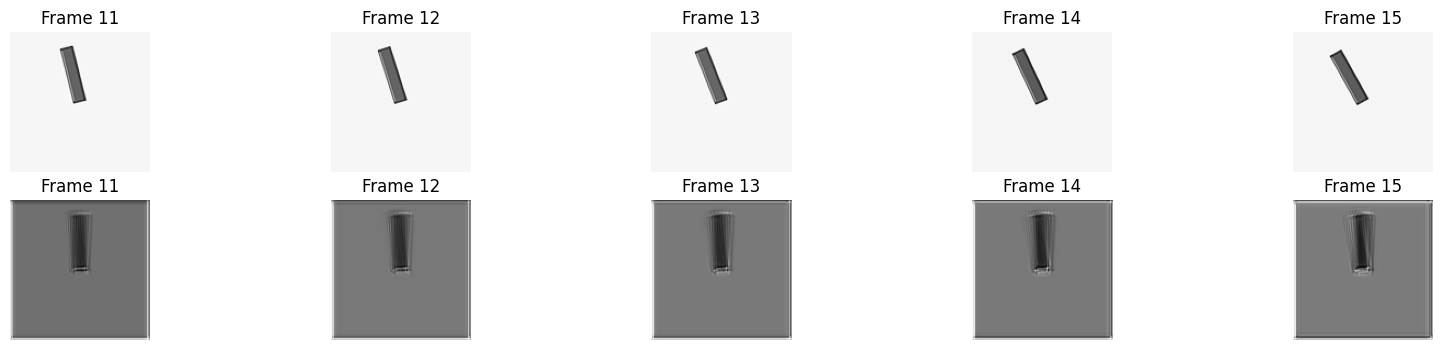

1/1 [==============================] - 0s 33ms/step


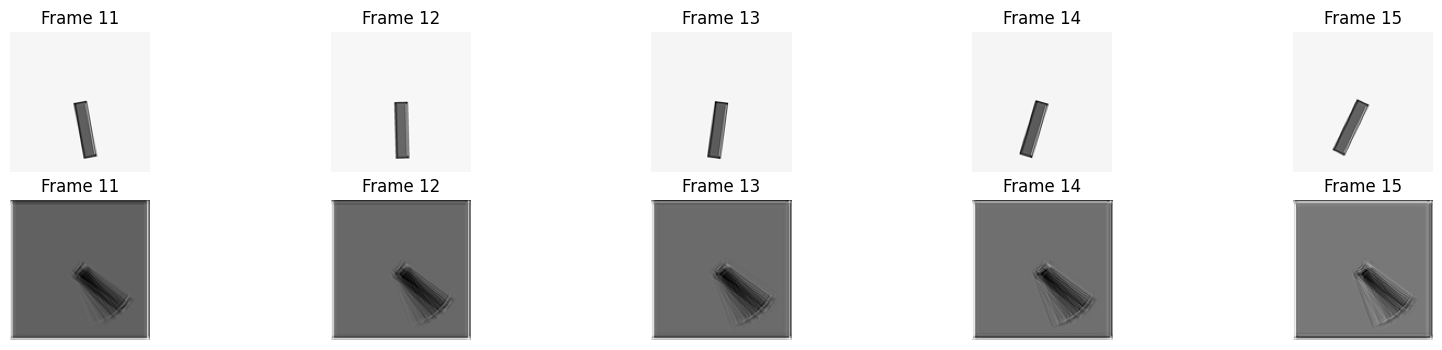

1/1 [==============================] - 0s 33ms/step


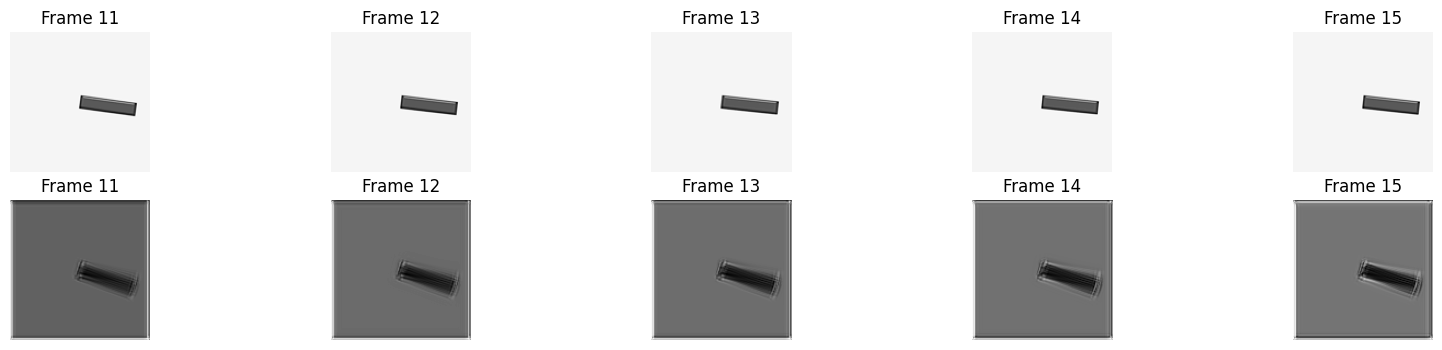

In [42]:
# for 300 training
for i in range(30):
    # Select a random example from the validation dataset.
    example = dataset[random.randrange(300,499)]

    # Pick the first/last ten frames from the example.
    frames = example[:5, ...]
    original_frames = example[5:, ...]

    # Predict a new set of 10 frames.
    for _ in range(5):
        # Extract the model's prediction and post-process it.
        new_prediction = seq.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        frames = np.concatenate((frames, predicted_frame), axis=0)

    # Construct a figure for the original and new frames.
    fig, axes = plt.subplots(2, 5, figsize=(20, 4))

    # Plot the original frames.
    for idx, ax in enumerate(axes[0]):
        ax.imshow(original_frames[idx], cmap='gray')
        ax.set_title(f"Frame {idx + 11}")
        ax.axis("off")

    # Plot the new frames.
    new_frames = frames[5:, ...]
    for idx, ax in enumerate(axes[1]):
        ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
        ax.set_title(f"Frame {idx + 11}")
        ax.axis("off")

    # Display the figure.
    index=0
    # plt.savefig("./r" + str(index) + ".png", bbox_inches="tight")
    index += 1
    plt.show()